In [14]:
import sys
sys.path.append("../lropy")

%load_ext autoreload
%autoreload complete

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
from pathlib import Path
from datetime import datetime, timedelta, timezone
from math import factorial
import itertools
import warnings
import pickle

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import LogLocator, NullLocator, FixedLocator
from matplotlib.lines import Line2D
import pandas as pd
import numpy as np
import seaborn as sns
import cartopy.crs as ccrs
from skimage.io import imread

In [90]:
from lropy.analysis.io import load_pickled_simulation_results
from lropy.analysis.io import pos_names, vel_names, acc_names, irr_names, panels_count_names
from lropy.analysis.plotting import format_plot, save_plot
from lropy.analysis.util import get_revolutions_index, get_day_index, trim_df, get_closest_before, get_closest_after, trim_df_revolutions, rmse, rrmse
from lropy.analysis.transform import cart2spher, cart2track, spher2cart, align_vectors
from lropy.analysis.spice_tools import get_distance, get_lro_beta_angle, as_et
from lropy.constants import JULIAN_DAY, moon_radius, earth_equatorial_radius, c, lro_period, astronomical_unit
from lropy.analysis.maps import moon_globe

In [17]:
def get_orbit_start(n_orbit):
    # 83 min to start opposite of subsolar point
    return pd.to_datetime(datetime(2010, 9, 26, 6) + timedelta(minutes=n_orbit*113) + timedelta(minutes=83), utc=True)

In [18]:
def get_orbit_number(time):
    time -= get_orbit_start(0)
    return (time.days * JULIAN_DAY + time.seconds) / lro_period

In [19]:
orbit_steps = int(lro_period / 5)
variable_columns = [
    "simulation_start", "use_solar_radiation", "use_moon_radiation", "target_type", "albedo_distribution_moon", "use_occultation"
]

plots_folder = "../paper/figures/plots"
tables_folder = "../paper/tables"

# Orbit geometry

Sun: 6.076454727187199e-08
Moon: 2.2923204712007033e-08


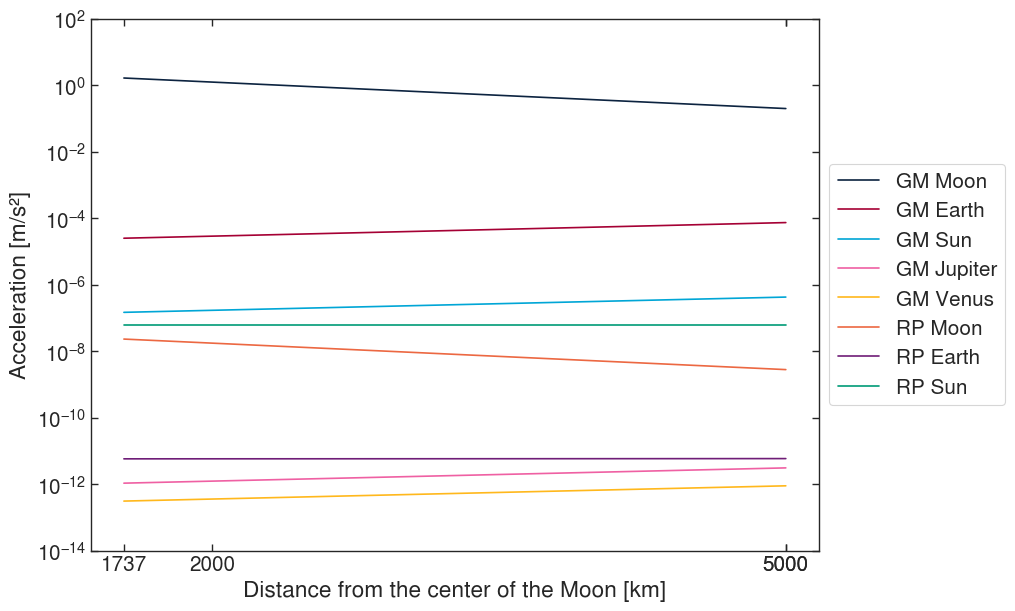

In [20]:
def plot_all_accelerations_magnitude():
    def grav_central(body, r, r_moon=None):
        gm = {
            "earth": 0.39860e6,
            "sun": 132712e6,
            "moon": 0.00490e6,
            "jupiter": 126.687e6,
            "venus": 0.32486e6
        }[body]  # km^3/s^2
    
        if body == "moon":
            # Regular central gravity
            return  gm / r**2 * 1e3
        else:
            # Perturbation
            return 2 * gm * r_moon / r**3 * 1e3
    
    # def grav_higher_order(n, m, r):
    #     def normalization_coeff(n, m):
    #         delta = 1 if m == 0 else 0
    #         return np.sqrt(factorial(n + m) / ((2 - delta) * (2*n + 1) * factorial(n - m)))
        
    #     J = {
    #         (2, 0): 9.088,
    #         (2, 2): 3.467e-5 + 9.079e-10,
    #     }[(n, m)] / normalization_coeff(n, m)
    #     return 0.00490e9 * 1738 ** n / r ** (n+2) * J

    def rp(body, r):
        A_m_Cp = 14.0 / 1087 * 1.0  # m^2/kg
        sun_luminosity = 3.828e26  # W

        if body == "sun":
            solar_irradiance = sun_luminosity / (4 * np.pi * r**2) / 1e6
            return A_m_Cp * solar_irradiance / c
        elif body == "moon":
            solar_irradiance = sun_luminosity / (4 * np.pi * r_moon_sun**2) / 1e6
            acc_rp_sun = A_m_Cp * solar_irradiance / c
            albedo = 0.15 / 2 * (moon_radius/1e3 / r)**2 * acc_rp_sun
            moon_thermal_irr = 900  # somewhat arbitrary average from Lemoine 2013, but order of magnitude not very sensitive to exact value
            thermal = 0.95 / 2 * A_m_Cp * moon_thermal_irr / c * (moon_radius/1e3 / r)**2
            return albedo + thermal
        elif body == "earth":
            solar_irradiance = sun_luminosity / (4 * np.pi * r_earth_sun**2) / 1e6
            acc_rp_sun = A_m_Cp * solar_irradiance / c
            return (0.34 / 2 + 0.68 / 4) * (earth_equatorial_radius/1e3 / r)**2 * acc_rp_sun
    
    r_moon_earth = 384400
    r_moon_sun = 146757375
    r_moon_jupiter = 744857858
    r_moon_venus = 154196622
    r_earth_sun = r_moon_sun

    rr_moon = np.linspace(moon_radius / 1e3, 5e3, 20)  # km
    rr_earth = r_moon_earth - rr_moon
    rr_sun = r_moon_sun -rr_moon
    rr_jupiter = r_moon_jupiter - rr_moon
    rr_venus = r_moon_venus - rr_moon

    fig, ax = plt.subplots(figsize=(10, 6))

    ax.plot(rr_moon, grav_central("moon", rr_moon), label="GM Moon")
    ax.plot(rr_moon, grav_central("earth", rr_earth, rr_moon), label="GM Earth")
    ax.plot(rr_moon, grav_central("sun", rr_sun, rr_moon), label="GM Sun")
    ax.plot(rr_moon, grav_central("jupiter", rr_jupiter, rr_moon), label="GM Jupiter")
    ax.plot(rr_moon, grav_central("venus", rr_venus, rr_moon), label="GM Venus")

    ax.plot(rr_moon, rp("moon", rr_moon), label="RP Moon")
    ax.plot(rr_moon, rp("earth", rr_earth), label="RP Earth")
    ax.plot(rr_moon, rp("sun", rr_sun), label="RP Sun")
    print("Sun:", rp("sun", rr_sun)[0])
    print("Moon:", rp("moon", rr_moon)[0])

    ax.set_xlabel("Distance from the center of the Moon [km]")
    ax.set_ylabel("Acceleration [m/s²]")
    ax.set_yscale("log")
    ax.set_xscale("log")
    ax.set_ylim([1e-14, 1e2])
    # ax.legend()
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    format_plot(x_major_locator=FixedLocator([rr_moon[0], 2e3, 5e3, rr_moon[-1]]), x_minor_locator=NullLocator())
    ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

plot_all_accelerations_magnitude()

Want to only consider accelerations much larger than RP which significantly determine orbit over 2.5 day arc.

# Lunar models

In [21]:
def tf_mosaic(dist):
    dist = dist.astype(np.double)
    dist -= 1
    dist /= 255
    dist = dist * (0.5 - 0.048) + 0.048
    return dist

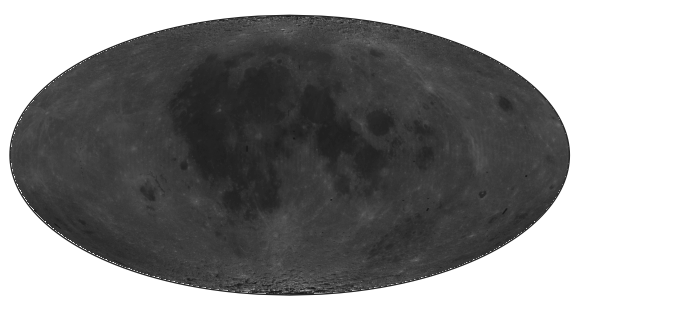

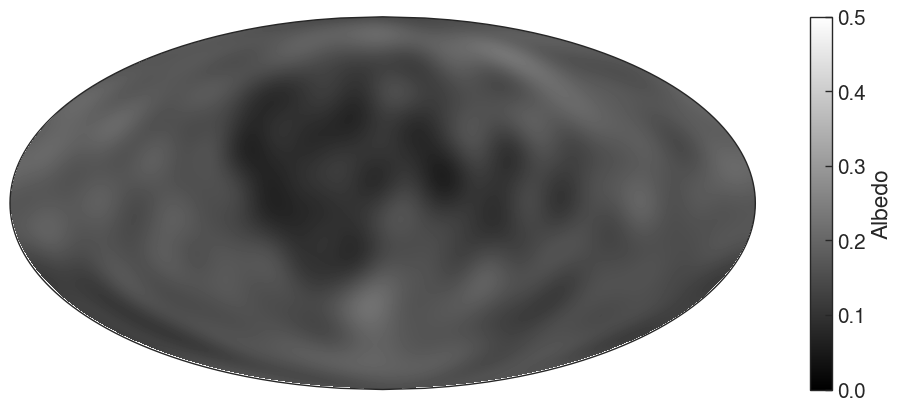

In [22]:
def plot_albedo_map():
    fig = plt.figure(figsize=(9*0.75, 4*0.75), constrained_layout=True)
    gs = matplotlib.gridspec.GridSpec(1, 2, figure=fig, width_ratios=[7, 0.92], wspace=0.1) 
    ax = fig.add_subplot(gs[0], projection=ccrs.Mollweide(globe=moon_globe))
    cax = fig.add_subplot(gs[1])
    dist = tf_mosaic(imread("files/albedo.jpg"))
    
    ax.imshow(dist, transform=ccrs.PlateCarree(globe=moon_globe), extent=(-180, 180, -90, 90), cmap="gray", vmin=0, vmax=0.5)
    # ax.gridlines(draw_labels=["bottom", "left"], crs=ccrs.PlateCarree(globe=moon_globe))
    cax.set_axis_off()
    save_plot(plots_folder, "lunar_map_photo")

    fig = plt.figure(figsize=(9, 4), constrained_layout=True)
    gs = matplotlib.gridspec.GridSpec(1, 2, figure=fig, width_ratios=[7, 0.2], wspace=0.1) 
    ax = fig.add_subplot(gs[0], projection=ccrs.Mollweide(globe=moon_globe))
    cax = fig.add_subplot(gs[1])
    dist = np.load("../private/dlam1.npy")
    im = ax.imshow(dist, transform=ccrs.PlateCarree(globe=moon_globe), extent=(-180, 180, -90, 90), cmap="gray", vmin=0, vmax=0.5)
    fig.colorbar(im, cax=cax, label="Albedo", use_gridspec=True)
    # ax.scatter([-11, 103], [-43, 36], marker="o", c="C3", s=40, transform=ccrs.PlateCarree(globe=moon_globe))
    save_plot(plots_folder, "lunar_map_dlam1")
    
plot_albedo_map()

0.04622745098039216 0.4982274509803922 0.1208333306632689 0.11890196078431373 0.2890666666666667
0.06003391558993548 0.22900066947748193 0.1536185939545239 0.15708577217377237 0.21109089058994587


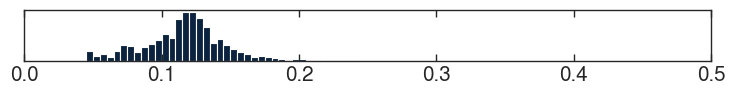

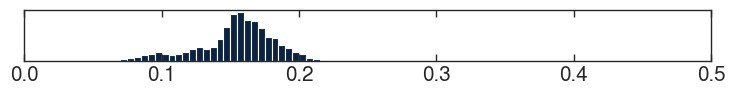

In [23]:
def plot_albedo_histogram(dist, file):
    fig, ax = plt.subplots(figsize=(9*0.8, 1*0.8))

    print(dist.min(), dist.max(), dist.mean(), np.median(dist), np.percentile(dist, 99))

    ax.hist(dist.flatten(), bins=100, density=True, range=[0, 0.5])
    # ax.set_xlabel("Albedo")
    ax.set_xlim([0, 0.5])
    ax.get_yaxis().set_visible(False)

    format_plot()
    save_plot(plots_folder, file)
    
plot_albedo_histogram(tf_mosaic(imread("files/albedo.jpg")), "lunar_hist_photo")
plot_albedo_histogram(np.load("../private/dlam1.npy"), "lunar_hist_dlam1")

5.670374419
1245.8181527278637


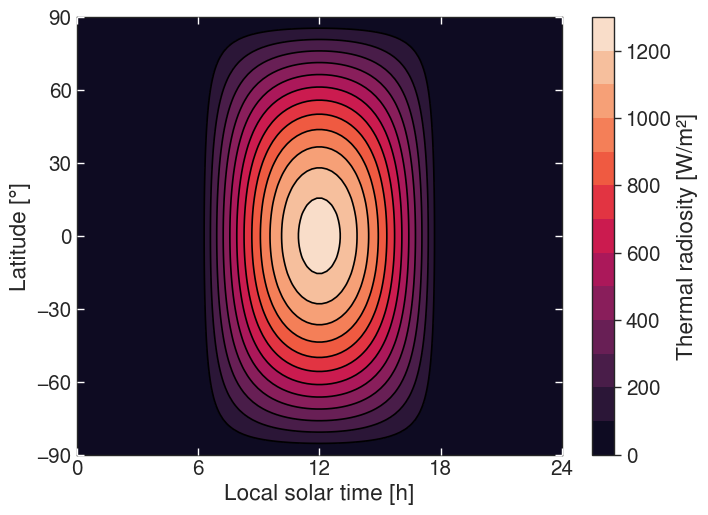

In [25]:
def thermal_radiation(polar, azimuth):
        subsolar = np.array([1, 0, 0])
        normal = np.array([
            np.cos(azimuth) * np.sin(polar),
            np.sin(azimuth) * np.sin(polar),
            np.cos(polar)
        ])
        cosphi = max(0, subsolar @ normal)
        
        sigma = 5.670374419e-8
        T = max(385 * cosphi**(1/4), 100)
        return sigma * T**4

def plot_thermal_lemoine():
    # Recreate Fig. 5 from Lemoine 2013
    polarlist = np.linspace(0, 1, 100) * np.pi
    azimuthlist = np.linspace(-1, 1, 100) * np.pi
    polars, azimuths = np.meshgrid(polarlist, azimuthlist)
    
    fig, ax = plt.subplots(figsize=(7, 5))
    exitances = np.vectorize(thermal_radiation)(polars, azimuths)
    im = ax.contourf((azimuths / np.pi + 1) * 12, 90 - np.degrees(polars), exitances, levels=12)
    ax.contour((azimuths / np.pi + 1) * 12, 90 - np.degrees(polars), exitances, levels=12, colors="black")
    cb = fig.colorbar(im, ax=ax, label=r"Thermal radiosity [W/m²]")

    ax.set_xlabel("Local solar time [h]")
    ax.set_ylabel("Latitude [°]")
    ax.tick_params(color="white")

    cb.ax.yaxis.tick_right()
    cb.ax.tick_params(direction="out", which="both")

    format_plot(
        x_major_locator=FixedLocator([0, 6, 12, 18, 24]),
        y_major_locator=FixedLocator(range(-90, 91, 30)),
    )
    save_plot(plots_folder, "thermal_map")
    
plot_thermal_lemoine()
print(thermal_radiation(0, 0))
print(thermal_radiation(np.pi / 2, 0))

# Paneling

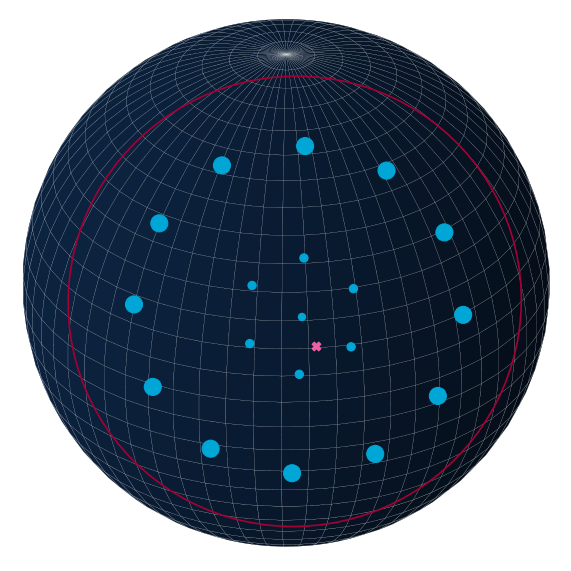

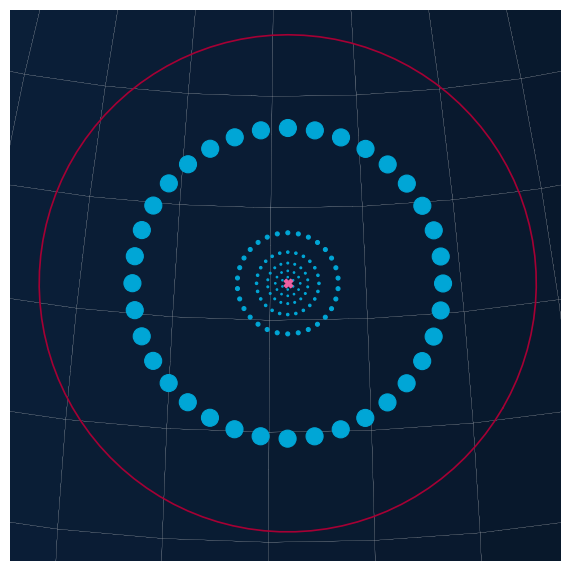

In [26]:
def calculate_cap_polar_angle(h, planet_radius):
    return np.arccos(planet_radius / (h + planet_radius))

def generate_panels_knocke(pos, n_panels_per_ring: list[int], R_e):
    # Initialize with central cap
    polars = [0]
    azimuths = [0]
    areas_from_geometry = []

    N = 1 + sum(n_panels_per_ring)

    r_s = np.linalg.norm(pos)

    zeta_m = np.arcsin(R_e / r_s)
    zeta_1 = np.arccos((N - 1 + np.cos(zeta_m)) / N)
    gamma_1 = np.arcsin(r_s * np.sin(zeta_1) / R_e)
    betas = [gamma_1 - zeta_1]

    area_central_cap = 2 * np.pi * R_e**2 * (1 - np.cos(betas[0]))
    areas_from_geometry.append(area_central_cap)

    k = 1
    for N_s in n_panels_per_ring:
        k += N_s
        zeta_i = np.arccos(k * np.cos(zeta_1) - k + 1)
        # gamma_i = np.arcsin(r_s * np.sin(zeta_i) / R_e)
        gamma_i = np.arcsin(min(1.0, r_s * np.sin(zeta_i) / R_e))
        betas.append(gamma_i - zeta_i)

        azimuths.extend(np.linspace(0, 2 * np.pi, N_s + 1)[:-1])

    for N_s, lower, upper in zip(n_panels_per_ring, betas[:-1], betas[1:]):
        beta_star = (lower + upper) / 2
        polars.extend([beta_star] * N_s)

        # Area from actual area on sphere
        areas_from_geometry.extend([2 * np.pi * R_e**2 * (np.cos(lower) - np.cos(upper)) / N_s] * N_s)

    assert len(polars) == len(areas_from_geometry)
    assert len(polars) == len(azimuths)
    assert len(polars) == sum(n_panels_per_ring) + 1

    rotation = align_vectors(np.array([0, 0, 1]), pos)
    polars_rotated = []
    azimuths_rotated = []

    for polar, azimuth in zip(polars, azimuths):
        coords_cartesian = spher2cart(R_e, polar, azimuth)
        # coords_cartesian_target_centric = rotation.apply(coords_cartesian)
        coords_cartesian_target_centric = rotation @ coords_cartesian
        coords_spherical_target_centric = cart2spher(*coords_cartesian_target_centric)
        polars_rotated.append(coords_spherical_target_centric[1] % (np.pi))
        azimuths_rotated.append(coords_spherical_target_centric[2] % (2 * np.pi))
    
    return polars_rotated, azimuths_rotated, np.array(areas_from_geometry)

def plot_dynamically_paneled_sphere(fig, ax, n_panels_per_ring: list[int], h, pos, zoom):
    pos = np.array(pos)

    radius = moon_radius / 1e3

    altitude = radius + h
    pos = pos / np.linalg.norm(pos) * altitude

    azimuths, polars = np.mgrid[0:2*np.pi:60j, 0:np.pi:30j]

    ax.plot_surface(*spher2cart(radius*0.99, polars, azimuths), alpha=1, linewidth=0.1, rasterized=True, rcount=1000, ccount=1000)
    
    panels = generate_panels_knocke(pos, n_panels_per_ring, radius)
    ax.scatter(*spher2cart(radius, *panels[:-1]), c="C2", label="panels", s=150 * panels[-1] / panels[-1].max(), depthshade=False)
    
    ax.scatter(*pos, marker="X", c="C3", s=40, label="spacecraft")

    # Nadir vector
    # ax.plot(*np.array([pos, pos / np.linalg.norm(pos) * radius]).T, c="white")

    # Draw circle of visible region
    cap_polar = calculate_cap_polar_angle(h, radius)
    rotation = align_vectors(np.array([0, 0, 1]), pos)
    visible_region = np.zeros((100, 3))

    for i, azimuth in enumerate(np.linspace(0, 2*np.pi, 100)):
        visible_region[i, :] = rotation @ np.array(spher2cart(radius*1.01, cap_polar, azimuth))
    ax.plot(*visible_region.T, c="C1", label="visible latitude", zorder=20)
    
    lim = radius * zoom
    ax.set_xlim([-lim*0.9, lim])
    ax.set_ylim([-lim, lim])
    ax.set_zlim([-lim, lim*1.1])
    ax.set_aspect("equal")

    ax.set_axis_off()

def plot_knocke_paneling():
    def get_ax():
        return plt.subplots(figsize=[12, 6], subplot_kw={"projection": "3d", "proj_type": "ortho"}, tight_layout=True)
    
    fig, ax = get_ax()
    plot_dynamically_paneled_sphere(fig, ax, [6, 12], 1500, [2, -3, 1.5], 0.59)
    save_plot(plots_folder, "knocke_paneling_high")

    fig, ax = get_ax()
    plot_dynamically_paneled_sphere(fig, ax, [6, 12, 18, 24, 30, 36], 50, [2, -3.45, 2.3], 0.15)
    save_plot(plots_folder, "knocke_paneling_low")

plot_knocke_paneling()

1 862.370313778972 48.936517780195764
2 1154.03315632715 31.666303190627175
3 1323.08559719817 21.656211040302587
4 1425.81996911014 15.573006772171682
5 1493.70518509213 11.553323506297597
6 1541.34431745453 8.732470388459635
7 1576.29859212592 6.662724996405068
8 1602.84174960973 5.0910265872928795
9 1618.37929174422 4.1710030268258595
10 1640.55301038815 2.858031940472505
11 1654.16017800498 2.052311531778117
12 1665.18094421654 1.399739556026125
13 1674.37267486741 0.8554701544007837
14 1682.15577467696 0.39460992719939636
15 1688.82002615269 0.0


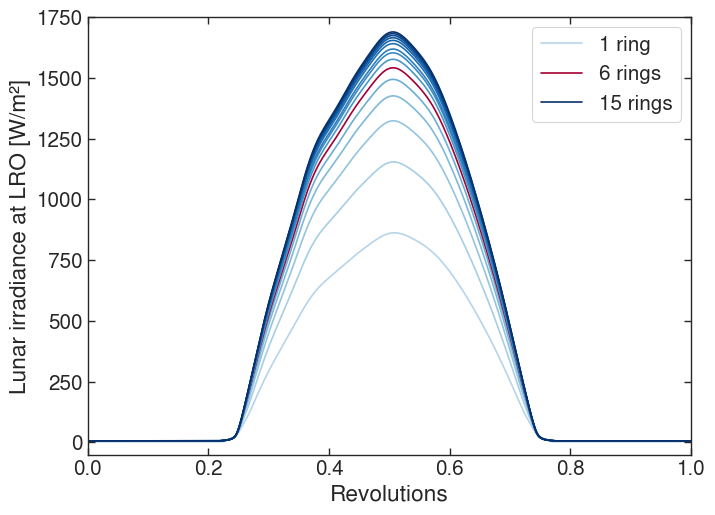

In [54]:
def plot_paneling_convergence():
    results_folder_rings = Path("../results/number_of_panels_per_ring_test-2023-08-30T09-44-40-d4d3e/")
    # results_folder_rings = Path("../results/number_of_panels_per_ring_test-2023-08-17T13-58-09-92f24/")
    metadata_rings, runs_rings = load_pickled_simulation_results(results_folder_rings)

    idxs = metadata_rings[
        (metadata_rings["albedo_distribution_moon"] == "DLAM1")
    ]
    dfs = {
        len(row.number_of_panels_per_ring_moon): runs_rings[row.Index] for row in idxs.itertuples()
    }
    dfs = dict(sorted(dfs.items(), key=lambda item: item[0]))
    dfs, labels = dfs.values(), dfs.keys()

    fig, ax = plt.subplots(1, 1, figsize=(7, 5), sharex="all")

    dfs = list(dfs)
    for i, df in enumerate(dfs):
        dfs[i] = trim_df(df, datetime(2010, 8, 26, 6, 57), datetime(2010, 8, 26, 8, 50))

    cmap = matplotlib.colormaps["Blues"](np.linspace(0.3, 1, len(dfs)))

    for df, label, color in zip(dfs, list(labels), cmap):
        print(label, df["irr_moon"].max(), abs(df["irr_moon"].max() / dfs[-1]["irr_moon"].max() - 1) * 100)
        if label == 6:
            color = "C1"
        if label in [1, 6, 15]:
            if label == 1:
                label = f"{label} ring"
            else:
                label = f"{label} rings"
        else:
            label=None
        ax.plot(get_revolutions_index(df), df["irr_moon"], label=label, c=color)

    ax.legend()

    ax.set_xlim([0, 1])
    ax.set_ylim([-50, 1751])
    ax.set_xlabel("Revolutions")
    ax.set_ylabel("Lunar irradiance at LRO [W/m²]")
    # ax.set_ylim([min(0, ax.get_ylim()[0]), ax.get_ylim()[1]])
    
    format_plot()
    save_plot(plots_folder, "paneling_convergence")
    
plot_paneling_convergence()

# Target model

In [28]:
def generate_target_model_table():
    panels = pd.DataFrame.from_records([
        ("+X", 0.29, 0.22, 2.82, ""),
        ("-X", 0.39, 0.19, 2.82, ""),
        ("+Y", 0.32, 0.23, 3.69, ""),
        ("-Y", 0.32, 0.18, 3.69, ""),
        ("+Z", 0.32, 0.18, 5.14, ""),
        ("-Z", 0.54, 0.18, 5.14, ""),
        ("+SA", 0.05, 0.05, 11.00, "+Sun or fixed"),
        ("-SA", 0.30, 0.20, 11.00, "-Sun or fixed"),
        ("+HGA", 0.18, 0.28, 1.00, "+Earth"),
        ("-HGA", 0.019, 0.0495, 1.00, "-Earth")
    ], columns=["Panel", "Cs", "Cd", "A", "Tracking"]).convert_dtypes()
    panels["Ca"] = 1 - panels["Cs"] - panels["Cd"]
    
    # num = (panels["Ca"] * 2/3 * panels["A"]).sum()
    # denom = ((panels["Cd"] * 5/3 + panels["Ca"] + 2 * panels["Cs"]) * panels["A"]).sum()
    
    panels = panels[["Panel", "Ca", "Cs", "Cd", "A", "Tracking"]].rename(columns={
        "Ca": "$\mathbf C_a$",
        "Cs": "$\mathbf C_s$",
        "Cd": "$\mathbf C_d$",
        "A": r"$\mathbf A$~[\unit{\meter\squared}]",
        "Tracking": r"\bfseries Tracking"
    })

    table = (
        panels.style
        .format(precision=2)
        .applymap_index(lambda v: "font-weight: bold;", axis="columns")
        .applymap(lambda v: "font-weight: bold;", "Panel")
        .hide(axis="index")
        .to_latex(convert_css=True, hrules=True)
    )
    
    print(table)
    with open(tables_folder + "/target_model.tex", "w") as f:
        f.write(table)

generate_target_model_table()

\begin{tabular}{lrrrrl}
\toprule
\bfseries Panel & \bfseries $\mathbf C_a$ & \bfseries $\mathbf C_s$ & \bfseries $\mathbf C_d$ & \bfseries $\mathbf A$~[\unit{\meter\squared}] & \bfseries Tracking \\
\midrule
\bfseries +X & 0.49 & 0.29 & 0.22 & 2.82 &  \\
\bfseries -X & 0.42 & 0.39 & 0.19 & 2.82 &  \\
\bfseries +Y & 0.45 & 0.32 & 0.23 & 3.69 &  \\
\bfseries -Y & 0.50 & 0.32 & 0.18 & 3.69 &  \\
\bfseries +Z & 0.50 & 0.32 & 0.18 & 5.14 &  \\
\bfseries -Z & 0.28 & 0.54 & 0.18 & 5.14 &  \\
\bfseries +SA & 0.90 & 0.05 & 0.05 & 11.00 & +Sun or fixed \\
\bfseries -SA & 0.50 & 0.30 & 0.20 & 11.00 & -Sun or fixed \\
\bfseries +HGA & 0.54 & 0.18 & 0.28 & 1.00 & +Earth \\
\bfseries -HGA & 0.93 & 0.02 & 0.05 & 1.00 & -Earth \\
\bottomrule
\end{tabular}



In [29]:
def load_mass_history():
    def parse_line(line):
        date = pd.to_datetime(line[56:73], format="%Y %j %H:%M:%S", utc=True)
        fuel_mass = float(line[104:111])
        return date, fuel_mass

    dry_mass = 1020.9
    history = []
    for f in Path("files/lro_sff").glob("*.txt"):
        line_start, line_stop, _, line_avg = f.open().readlines()[2:6]
        average_mass = float(line_avg[103:111])
        history.append(parse_line(line_start) + (average_mass,))
        history.append(parse_line(line_stop) + (average_mass,))
    
    history = pd.DataFrame(history, columns=["date", "fuel_mass", "average_mass"]).set_index("date").sort_index()
    history["mass"] = dry_mass + history["fuel_mass"]
    return history

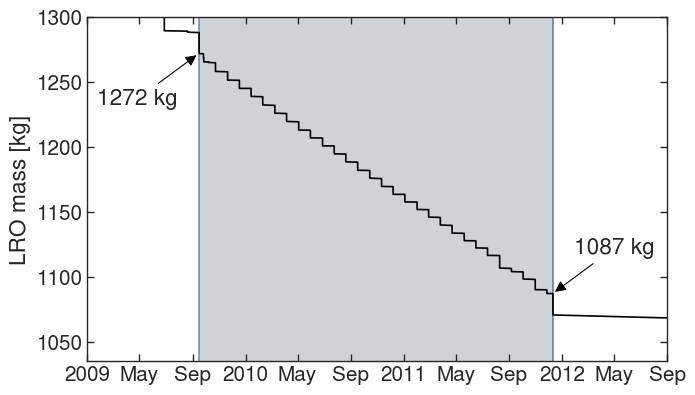

In [118]:
def plot_mass_history():
    mass_history = load_mass_history()

    fig, ax = plt.subplots(figsize=(7, 3.8))

    ax.axvline(datetime(2009, 9, 16), alpha=0.5)  # actually September 15
    ax.axvline(datetime(2011, 12, 11), alpha=0.5)  # actually December 11
    ax.axvspan(datetime(2009, 9, 16), datetime(2011, 12, 11), alpha=0.2)

    # ax.annotate("LRO science mission", (datetime(2009, 9, 15), 1350), xytext=(5, -5), textcoords="offset points", va="top")

    start_mass = get_closest_before(mass_history, datetime(2009, 9, 16, tzinfo=timezone.utc))["mass"]
    ax.annotate(
        f"{start_mass:.0f} kg",
        (datetime(2009, 9, 15), start_mass),
        xytext=(-15, -25),
        va="top",
        ha="right",
        textcoords="offset points",
        arrowprops=dict(arrowstyle="-|>", color="black")
    )

    end_mass = get_closest_after(mass_history, datetime(2011, 12, 10, tzinfo=timezone.utc))["mass"]
    ax.annotate(
        f"{end_mass:.0f} kg",
        (datetime(2011, 12, 11), end_mass),
        xytext=(15, 25),
        va="bottom",
        ha="left",
        textcoords="offset points",
        arrowprops=dict(arrowstyle="-|>", color="black")
    )

    ax.plot(mass_history.index, mass_history["mass"], color="black")

    # ax.set_xlabel("Date")
    ax.set_ylabel("LRO mass [kg]")
    ax.set_xlim([datetime(2009, 1, 1), datetime(2012, 9, 1)])
    ax.set_ylim([1035, 1300])

    # ax.set_xticklabels(ax.get_xticklabels())

    format_plot(x_major_locator=matplotlib.dates.AutoDateLocator())
    ax.xaxis.set_major_formatter(matplotlib.dates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
    save_plot(plots_folder, "mass_history")

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    plot_mass_history()

# Performance benchmark

In [31]:
metadata_benchmark = load_pickled_simulation_results("../results/full-benchmark-2023-08-20T17-47-25-f9c57")
# metadata_benchmark = load_pickled_simulation_results("../results/full-benchmark-2023-08-20T12-38-39-779f0")
# metadata_benchmark = load_pickled_simulation_results("../results/full-benchmark-2023-08-17T15-23-23-792e0")
metadata_benchmark = metadata_benchmark[variable_columns + ["walltime_propagation", "walltime_total"]]

In [32]:
# Average over dates
# metadata_benchmark = metadata_benchmark\
#     .groupby(list(set(variable_columns) - set(["simulation_start"])))\
#     .agg({"walltime_propagation": "mean", "walltime_total": "sum"})\
#     .reset_index()
metadata_benchmark

simulation_start use_solar_radiation use_moon_radiation target_type  \
1   2010 JUN 28 15:00:00               False               True     Paneled   
2   2010 JUN 28 15:00:00               False               True  Cannonball   
3   2010 JUN 28 15:00:00                True               True     Paneled   
4   2010 JUN 28 15:00:00                True               True  Cannonball   
5   2010 JUN 28 15:00:00                True              False  Cannonball   
6   2010 JUN 28 15:00:00               False               True  Cannonball   
7   2010 JUN 28 15:00:00                True               True  Cannonball   
8   2010 JUN 28 15:00:00               False               True     Paneled   
9   2010 JUN 28 15:00:00                True               True     Paneled   
10  2010 JUN 28 15:00:00                True              False     Paneled   
11  2010 JUN 28 15:00:00               False              False     Paneled   

   albedo_distribution_moon use_occultation walltime_propagation  \
1                     DLAM1            True           525.325568   
2                     DLAM1            True           492.534501   
3                     DLAM1            True            548.39275   
4                     DLAM1            True           536.229379   
5                                      True           256.118371   
6                  Constant            True           303.058657   
7                  Constant            True           307.884597   
8                  Constant            True           319.872447   
9                  Constant            True            324.13208   
10                                     True           266.264372   
11                                     True           257.585647   

                                       walltime_total  
1   [548.6452349722385, 551.4711567740887, 549.125...  
2   [529.8537656683475, 535.7902817893773, 536.950...  
3   [550.6764173060656, 551.5413239300251, 552.431...  
4   [531.2973781842738, 535.6057688239962, 531.804...  
5   [256.2216253243387, 259.4951489754021, 259.550...  
6   [301.107066988945, 301.8122032415122, 302.8144...  
7   [304.41842352226377, 306.21535154245794, 305.6...  
8   [321.8200543113053, 322.7203735616058, 324.776...  
9   [323.90160901658237, 327.32507390901446, 340.8...  
10  [267.53691129758954, 267.81963201984763, 268.9...  
11  [255.5407854653895, 257.69285506755114, 256.29...

In [33]:
def get_benchmark_times(use_solar, use_lunar, target_type, albedo, use_occultation):
    df = metadata_benchmark[
        (metadata_benchmark["use_solar_radiation"] == use_solar) &
        (metadata_benchmark["use_moon_radiation"] == use_lunar) &
        (metadata_benchmark["target_type"] == target_type) &
        (metadata_benchmark["albedo_distribution_moon"] == albedo) &
        (metadata_benchmark["use_occultation"] == use_occultation)
    ]
    if len(df.index) > 1:
        raise ValueError("More than one run found")
    return np.array(df.iloc[0]["walltime_total"])

In [34]:
# fig, ax = plt.subplots()

# sns.stripplot(x=get_benchmark_times("2010 JUN 26", False, True, "Paneled", "DLAM1", True), ax=ax, label="2010 JUN 26")
# sns.stripplot(x=get_benchmark_times("2010 SEP 26", False, True, "Paneled", "DLAM1", True), ax=ax, label="2010 SEP 26")
# sns.pointplot(x=get_benchmark_times("2010 JUN 26", False, True, "Paneled", "DLAM1", True), ax=ax, label="2010 JUN 26", markers="d", ci=None)
# sns.pointplot(x=get_benchmark_times("2010 SEP 26", False, True, "Paneled", "DLAM1", True), ax=ax, label="2010 SEP 26", markers="d", ci=None)
# ax.legend()

Cannonball 
 [4.28609442 4.31779763 5.05462164 8.86833743] 
 [2.68426235 3.13915602 4.03388251 3.99747926] 
 [20.59707672 10.0373924  13.44863086 10.62686995] 

Paneled 
 [4.28609442 4.45679495 5.40158647 9.22175882] 
 [2.68426235 2.54840189 3.62349956 5.3114619 ] 
 [20.59707672 11.99736433 11.65792777  9.13594696] 



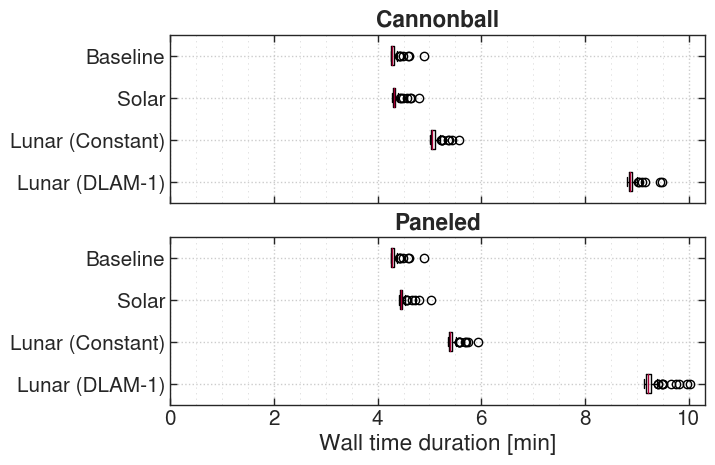

In [35]:
def plot_performance():
    fig, axs = plt.subplots(2, figsize=(7, 4.5), sharex="all")
    
    for ax, target_type in zip(axs, ["Cannonball", "Paneled"]):
        times_baseline = get_benchmark_times(False, False, "Paneled", "", True)
        times_solar = get_benchmark_times(True, False, target_type, "", True)
        times_lunar_const = get_benchmark_times(True, True, target_type, "Constant", True)
        times_lunar_dlam = get_benchmark_times(True, True, target_type, "DLAM1", True)

        times = [times_baseline / 60, times_solar / 60, times_lunar_const / 60, times_lunar_dlam / 60]
        print(
            target_type, "\n",
             np.median(times, axis=1), "\n",
            (np.percentile(times, 75, axis=1) - np.percentile(times, 25, axis=1))*60, "\n",
            (np.max(times, axis=1) - np.median(times, axis=1)) / (np.median(times, axis=1) - np.min(times, axis=1)), "\n",
            )

        ax.boxplot(
            times,
            labels=["Baseline", "Solar", "Lunar (Constant)", "Lunar (DLAM-1)"],
            vert=False
        )

        # ax.set_xticklabels(ax.get_xticklabels(), ha="center", rotation=15)
        ax.set_title(target_type)
        ax.invert_yaxis()
    
    axs[0].set_xlim([0, max([ax.get_xlim()[1] for ax in axs])])
    
    axs[-1].set_xlabel("Wall time duration [min]")

    format_plot(
        major_grid=True, minor_grid=True,
        y_major_locator=ax.get_yaxis().get_major_locator(), y_minor_locator=NullLocator())
    save_plot(plots_folder, "performance")

plot_performance()

# Effect of instantaneous reradiation

                                               0             1             2
Solar         2011 SEP 26 18:00:00  1.738080e-08  1.913359e-08  4.884430e-10
              2010 JUN 28 15:00:00  3.329818e-10  1.326517e-08  1.942136e-08
Lunar         2011 SEP 26 18:00:00  8.635328e-09  2.319600e-09  3.105514e-11
              2010 JUN 28 15:00:00  1.032149e-10  2.197266e-10  3.188425e-10
Solar + Lunar 2011 SEP 26 18:00:00  9.254726e-09  1.815581e-08  4.910603e-10
              2010 JUN 28 15:00:00  3.821600e-10  1.347914e-08  1.973071e-08


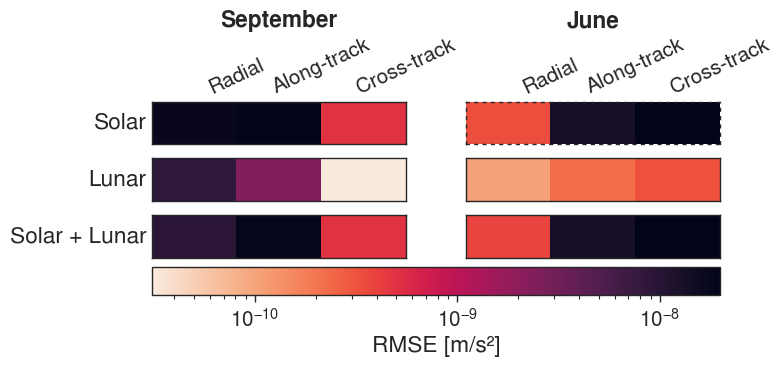

In [36]:
def plot_instant_reradiation_diffs():
    results_folder_rerad = Path("../results/instantaneous_reradiation_test-2023-08-19T11-39-01-0e203")
    metadata_rerad, runs_rerad = load_pickled_simulation_results(results_folder_rerad)
    metadata_rerad = metadata_rerad[metadata_rerad["use_solar_radiation"] & metadata_rerad["use_moon_radiation"]]

    sources = ["Solar", "Lunar", "Solar + Lunar"]
    dates = metadata_rerad["simulation_start"].unique()

    rms = {}

    for source, date in itertools.product(sources, dates):
        df_with = runs_rerad[
            metadata_rerad[
                (metadata_rerad["simulation_start"] == date) & metadata_rerad["with_instantaneous_reradiation"].astype(bool)
        ].index[0]]
        df_without = runs_rerad[
            metadata_rerad[
                (metadata_rerad["simulation_start"] == date) & ~metadata_rerad["with_instantaneous_reradiation"].astype(bool)
        ].index[0]]
        df_with = trim_df_revolutions(df_with)
        df_without = trim_df_revolutions(df_without)

        rms_run = []
        for comp in ["radial", "along", "cross"]:
            if source == "Solar":
                ser_with = df_with["acc_rp_sun_" + comp]
                ser_without = df_without["acc_rp_sun_" + comp]
            elif source == "Lunar":
                ser_with = df_with["acc_rp_moon_" + comp]
                ser_without = df_without["acc_rp_moon_" + comp]
            elif source == "Solar + Lunar":
                ser_with = df_with["acc_rp_sun_" + comp] + df_with["acc_rp_moon_" + comp]
                ser_without = df_without["acc_rp_sun_" + comp] + df_without["acc_rp_moon_" + comp]
            
            rms_run.append(rmse(ser_with, ser_without))

        rms[(source, date)] = rms_run
    
    print(pd.DataFrame(rms).T)

    fig, axs = plt.subplots(3, 2, figsize=(7*1.1, 3.2*1.1), constrained_layout=True)

    minmin = np.min(list(rms.values()))
    maxmax = np.max(list(rms.values()))
    norm = matplotlib.colors.LogNorm(vmin=minmin, vmax=maxmax)
    cmap = "rocket_r"

    for (i, source), (j, date) in itertools.product(enumerate(sources), enumerate(dates)):
        ax = axs[i, j]
        ax.imshow(np.atleast_2d(rms[(source, date)]), cmap=cmap, norm=norm, aspect=0.5)
        ax.tick_params(left=False, bottom=False, right=False, top=False, labelleft=False, labelbottom=False)

        if source == "Solar" and "JUN" in date:
            ax.spines[:].set_linestyle((0, (2, 4)))
    
    for i, source in enumerate(sources):
        ax = axs[i, 0]
        ax.set_ylabel(source, rotation=0, ha="right", va="center")

    for j, date in enumerate(dates):
        ax = axs[0, j]
        ax.set_title({
            "2010 JUN 28 15:00:00": "June",
            "2011 SEP 26 18:00:00": "September",
        }[date])
        ax.tick_params(labeltop=True, labelrotation=25)
        ax.set_xticks([0.5, 1.5, 2.5], ["Radial", "Along-track", "Cross-track"], ha="center")
    
    cb = fig.colorbar(
        matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap), ax=axs,
        orientation='horizontal',
        fraction=.2, pad=0.05)
    cb.ax.set_xlabel("RMSE [m/s²]")
    cb.ax.tick_params(direction="out", which="both")
    cb.ax.xaxis.set_major_locator(matplotlib.ticker.LogLocator(base=10, subs="auto"))
    cb.update_ticks()

    save_plot(plots_folder, "acc_reradiation_rms")

plot_instant_reradiation_diffs()

                                            0           1          2
Solar         2011 SEP 26 18:00:00  39.293244   45.757254  32.115047
              2010 JUN 28 15:00:00  70.222138  565.695724  33.298427
Lunar         2011 SEP 26 18:00:00  26.612498   38.400003   9.475095
              2010 JUN 28 15:00:00  14.996651  138.738653  38.153366
Solar + Lunar 2011 SEP 26 18:00:00  74.374149   46.790190  38.079118
              2010 JUN 28 15:00:00  47.898734  538.738893  33.362636


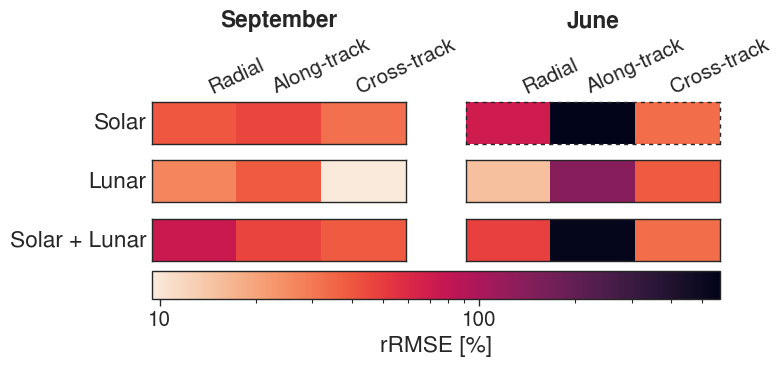

In [37]:
def plot_instant_reradiation_relative_diffs():
    results_folder_rerad = Path("../results/instantaneous_reradiation_test-2023-08-19T11-39-01-0e203")
    metadata_rerad, runs_rerad = load_pickled_simulation_results(results_folder_rerad)
    metadata_rerad = metadata_rerad[metadata_rerad["use_solar_radiation"] & metadata_rerad["use_moon_radiation"]]

    sources = ["Solar", "Lunar", "Solar + Lunar"]
    dates = metadata_rerad["simulation_start"].unique()

    rms = {}

    for source, date in itertools.product(sources, dates):
        df_with = runs_rerad[
            metadata_rerad[
                (metadata_rerad["simulation_start"] == date) & metadata_rerad["with_instantaneous_reradiation"].astype(bool)
        ].index[0]]
        df_without = runs_rerad[
            metadata_rerad[
                (metadata_rerad["simulation_start"] == date) & ~metadata_rerad["with_instantaneous_reradiation"].astype(bool)
        ].index[0]]
        df_with = trim_df_revolutions(df_with)
        df_without = trim_df_revolutions(df_without)

        rms_run = []
        for comp in ["radial", "along", "cross"]:
            if source == "Solar":
                ser_with = df_with["acc_rp_sun_" + comp]
                ser_without = df_without["acc_rp_sun_" + comp]
            elif source == "Lunar":
                ser_with = df_with["acc_rp_moon_" + comp]
                ser_without = df_without["acc_rp_moon_" + comp]
            elif source == "Solar + Lunar":
                ser_with = df_with["acc_rp_sun_" + comp] + df_with["acc_rp_moon_" + comp]
                ser_without = df_without["acc_rp_sun_" + comp] + df_without["acc_rp_moon_" + comp]
            
            rms_run.append(rrmse(ser_with, ser_without) * 100)

        rms[(source, date)] = rms_run
        
    print(pd.DataFrame(rms).T)

    fig, axs = plt.subplots(3, 2, figsize=(7*1.1, 3.2*1.1), constrained_layout=True)

    minmin = np.min(list(rms.values()))
    maxmax = np.max(list(rms.values()))
    norm = matplotlib.colors.LogNorm(vmin=minmin, vmax=maxmax)
    cmap = "rocket_r"

    for (i, source), (j, date) in itertools.product(enumerate(sources), enumerate(dates)):
        ax = axs[i, j]
        ax.imshow(np.atleast_2d(rms[(source, date)]), cmap=cmap, norm=norm, aspect=0.5)
        ax.tick_params(left=False, bottom=False, right=False, top=False, labelleft=False, labelbottom=False)

        if source == "Solar" and "JUN" in date:
            ax.spines[:].set_linestyle((0, (2, 4)))
    
    for i, source in enumerate(sources):
        ax = axs[i, 0]
        ax.set_ylabel(source, rotation=0, ha="right", va="center")

    for j, date in enumerate(dates):
        ax = axs[0, j]
        ax.set_title({
            "2010 JUN 28 15:00:00": "June",
            "2011 SEP 26 18:00:00": "September",
        }[date])
        ax.tick_params(labeltop=True, labelrotation=25)
        ax.set_xticks([0.5, 1.5, 2.5], ["Radial", "Along-track", "Cross-track"], ha="center")
    
    cb = fig.colorbar(
        matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap), ax=axs,
        orientation='horizontal',
        fraction=.2, pad=0.05)
    cb.ax.set_xlabel("rRMSE [%]")
    cb.ax.tick_params(direction="out", which="both")
    cb.ax.xaxis.set_major_locator(matplotlib.ticker.LogLocator(base=10, subs="auto"))
    cb.update_ticks()
    cb.ax.xaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter("{x:.0f}"))

    save_plot(plots_folder, "acc_reradiation_rrms")


plot_instant_reradiation_relative_diffs()

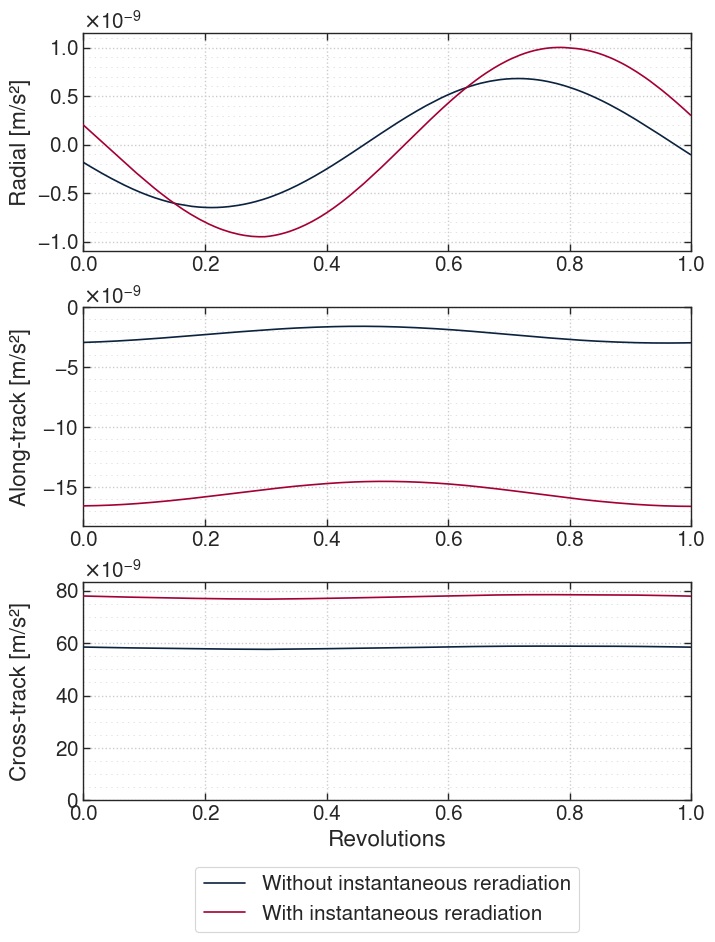

In [117]:
def plot_instant_reradiation_acc(source, start_date, start_rev, filename):
    results_folder_rerad = Path("../results/instantaneous_reradiation_test-2023-08-19T11-39-01-0e203")
    metadata_rerad, runs_rerad = load_pickled_simulation_results(results_folder_rerad)

    fig, axs = plt.subplots(3, figsize=(7, 9.2))

    df_with_rerad = runs_rerad[
        metadata_rerad[
            (metadata_rerad["simulation_start"] == start_date) &
            metadata_rerad["use_moon_radiation"] &
            metadata_rerad["use_solar_radiation"] &
            metadata_rerad["with_instantaneous_reradiation"].astype(bool)
    ].index[0]]
    df_without_rerad = runs_rerad[
        metadata_rerad[
            (metadata_rerad["simulation_start"] == start_date) &
            metadata_rerad["use_moon_radiation"] &
            metadata_rerad["use_solar_radiation"] &
            ~metadata_rerad["with_instantaneous_reradiation"].astype(bool)
    ].index[0]]

    df_without_rerad = trim_df_revolutions(df_without_rerad, start_rev)
    df_with_rerad = trim_df_revolutions(df_with_rerad, start_rev)

    for comp, ax in zip(["radial", "along", "cross"], axs):
        if comp == "magnitude":
            col = f"acc_rp_{source}"
        else:
            col = f"acc_rp_{source}_{comp}"

        ax.plot(df_without_rerad.index, df_without_rerad[col], label="Without instantaneous reradiation", zorder=3)
        ax.plot(df_with_rerad.index, df_with_rerad[col], label="With instantaneous reradiation", zorder=4)
        # ax.plot(df_with_rerad.index, df_with_rerad[col] * df_without_rerad[col].abs().max() / df_with_rerad[col].abs().max(), label="With instantaneous reradiation (scaled)", c="C1", alpha=0.5, zorder=2)
    
    for ax in axs.flat:
        ax.ticklabel_format(axis="y", style="sci", scilimits=(-9, -9), useMathText=True)
        ax.set_ylim([min(0, ax.get_ylim()[0] * 1.05), max(0, ax.get_ylim()[1] * 1.05)])
        ax.set_xlim([0, 1])
    
    for ax, name in zip(axs.flat, ["Radial", "Along-track", "Cross-track"]):
        # First column
        ax.set_ylabel(name + r" [m/s²]")

    axs[-1].set_xlabel("Revolutions")
    axs[-1].legend(bbox_to_anchor=(0.5, -0.65), loc="lower center")

    format_plot(major_grid=True, minor_grid=True, x_minor_locator=NullLocator())
    save_plot(plots_folder, filename)

plot_instant_reradiation_acc("sun", "2010 JUN 28 15:00:00", 0.1, "acc_reradiation_sun_jun")

# Load data

In [91]:
results_folder = Path("../results/full-2023-08-30T00-33-58-482c6")  # fixed DLAM-1
# results_folder = Path("../results/full-2023-08-20T12-00-58-de219")  # original paper
metadata, runs = load_pickled_simulation_results(results_folder)
metadata["albedo_distribution_moon"] = metadata["albedo_distribution_moon"].replace({
    "DLAM1": "DLAM-1",
    "Constant": "constant"
})

In [92]:
metadata[variable_columns]

simulation_start use_solar_radiation use_moon_radiation target_type  \
1   2011 SEP 26 18:00:00               False               True  Cannonball   
2   2010 JUN 28 15:00:00               False               True     Paneled   
3   2011 SEP 26 18:00:00               False               True     Paneled   
4   2010 JUN 28 15:00:00               False               True     Paneled   
5   2010 JUN 28 15:00:00                True               True  Cannonball   
6   2011 SEP 26 18:00:00               False               True     Paneled   
7   2011 SEP 26 18:00:00                True               True     Paneled   
8   2010 JUN 28 15:00:00               False               True  Cannonball   
9   2010 JUN 28 15:00:00               False               True  Cannonball   
10  2011 SEP 26 18:00:00                True               True  Cannonball   
11  2010 JUN 28 15:00:00                True               True  Cannonball   
12  2011 SEP 26 18:00:00               False               True  Cannonball   
13  2011 SEP 26 18:00:00               False               True     Paneled   
14  2010 JUN 28 15:00:00               False               True     Paneled   
15  2011 SEP 26 18:00:00                True               True     Paneled   
16  2010 JUN 28 15:00:00                True               True  Cannonball   
17  2011 SEP 26 18:00:00                True              False     Paneled   
18  2011 SEP 26 18:00:00               False               True  Cannonball   
19  2011 SEP 26 18:00:00                True               True  Cannonball   
20  2010 JUN 28 15:00:00                True               True     Paneled   
21  2011 SEP 26 18:00:00               False               True     Paneled   
22  2011 SEP 26 18:00:00                True               True  Cannonball   
23  2011 SEP 26 18:00:00                True              False  Cannonball   
24  2010 JUN 28 15:00:00               False               True  Cannonball   
25  2011 SEP 26 18:00:00                True               True     Paneled   
26  2010 JUN 28 15:00:00                True              False     Paneled   
27  2010 JUN 28 15:00:00                True               True     Paneled   
28  2010 JUN 28 15:00:00                True               True     Paneled   
29  2011 SEP 26 18:00:00                True               True     Paneled   
30  2010 JUN 28 15:00:00               False               True     Paneled   
31  2011 SEP 26 18:00:00                True               True     Paneled   
32  2010 JUN 28 15:00:00               False               True  Cannonball   
33  2010 JUN 28 15:00:00                True               True  Cannonball   
34  2011 SEP 26 18:00:00                True               True  Cannonball   
35  2010 JUN 28 15:00:00                True               True     Paneled   
36  2010 JUN 28 15:00:00                True               True     Paneled   
37  2010 JUN 28 15:00:00                True              False  Cannonball   
38  2011 SEP 26 18:00:00               False               True  Cannonball   
39  2011 SEP 26 18:00:00                True               True  Cannonball   
40  2010 JUN 28 15:00:00               False               True     Paneled   
41  2011 SEP 26 18:00:00               False               True     Paneled   
42  2011 SEP 26 18:00:00               False               True  Cannonball   
43  2010 JUN 28 15:00:00               False               True  Cannonball   
44  2010 JUN 28 15:00:00                True               True  Cannonball   
45  2010 JUN 28 15:00:00               False              False  Cannonball   
46  2011 SEP 26 18:00:00               False              False  Cannonball   

   albedo_distribution_moon use_occultation  
1                    DLAM-1            True  
2                    DLAM-1            True  
3                    DLAM-1            True  
4                  constant            True  
5                  NoAlbedo            True  
6                 

In [93]:
simulation_dates = list(metadata["simulation_start"].unique())
simulation_dates

['2011 SEP 26 18:00:00', '2010 JUN 28 15:00:00']

In [94]:
def get_baseline(start_date):
    for date in metadata["simulation_start"].unique():
        if date.startswith(start_date):
            start_date = date
            break

    df = metadata[
        (metadata["simulation_start"] == start_date) &
        (metadata["use_solar_radiation"] == False) &
        (metadata["use_moon_radiation"] == False)
    ]
    if len(df.index) > 1:
        raise ValueError("More than one run found")
    return runs[df.index[0]].copy()

In [95]:
def get_run(start_date, use_solar, use_lunar, target_type, albedo, thermal):
    for date in metadata["simulation_start"].unique():
        if date.startswith(start_date):
            start_date = date
            break

    df = metadata[
        (metadata["simulation_start"] == start_date) &
        (metadata["use_solar_radiation"] == use_solar) &
        (metadata["use_moon_radiation"] == use_lunar) &
        (metadata["target_type"] == target_type) &
        (metadata["albedo_distribution_moon"] == albedo) &
        (metadata["thermal_type_moon"] == thermal)
    ]
    if len(df.index) > 1:
        raise ValueError("More than one run found")
    return runs[df.index[0]].copy()

# Orbit geometry

In [96]:
duration = metadata["simulation_duration"].iloc[0]
for start_date in metadata["simulation_start"].unique():
    print(start_date)
    start_date_et = as_et(start_date)
    print(" Beta", get_lro_beta_angle(start_date_et))
    print(" Sun distance", get_distance("Sun", "LRO", start_date_et) / astronomical_unit)

    end_date_et = start_date_et + duration
    print(" Beta", get_lro_beta_angle(end_date_et))
    print(" Sun distance", get_distance("Sun", "LRO", end_date_et) / astronomical_unit)

    h = get_baseline(start_date)["h"] / 1e3
    print(" Altitude range", h.min(), h.max())

    print()

2011 SEP 26 18:00:00
 Beta -1.7095639214208802
 Sun distance 1.0002599966486814
 Beta -3.5557992386268182
 Sun distance 0.9997387761189371
 Altitude range 36.450651669237295 65.3104140359084

2010 JUN 28 15:00:00
 Beta 88.88225981064335
 Sun distance 1.0190047947159588
 Beta 88.78453027686777
 Sun distance 1.0183046853123707
 Altitude range 37.029231540819396 64.17332282535939



# Accelerations

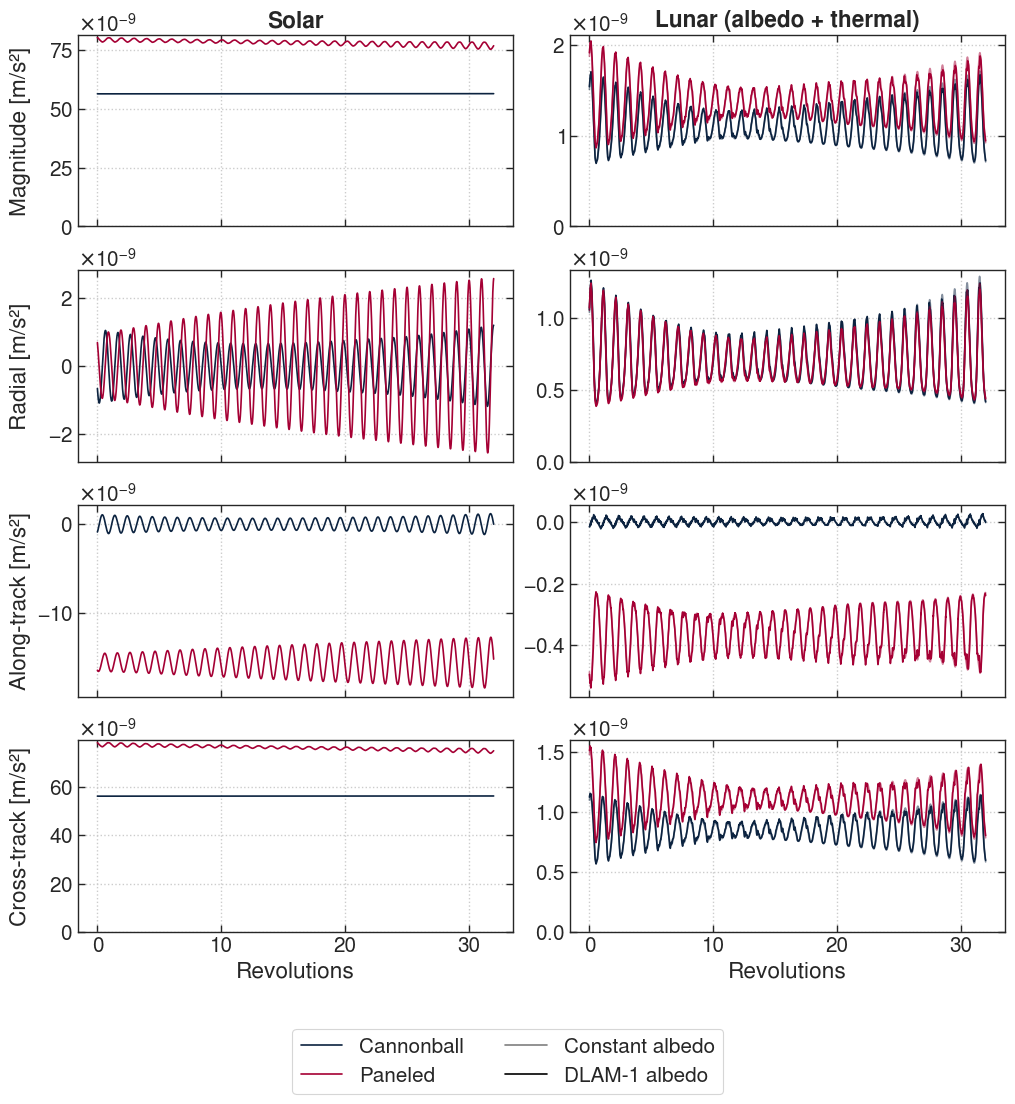

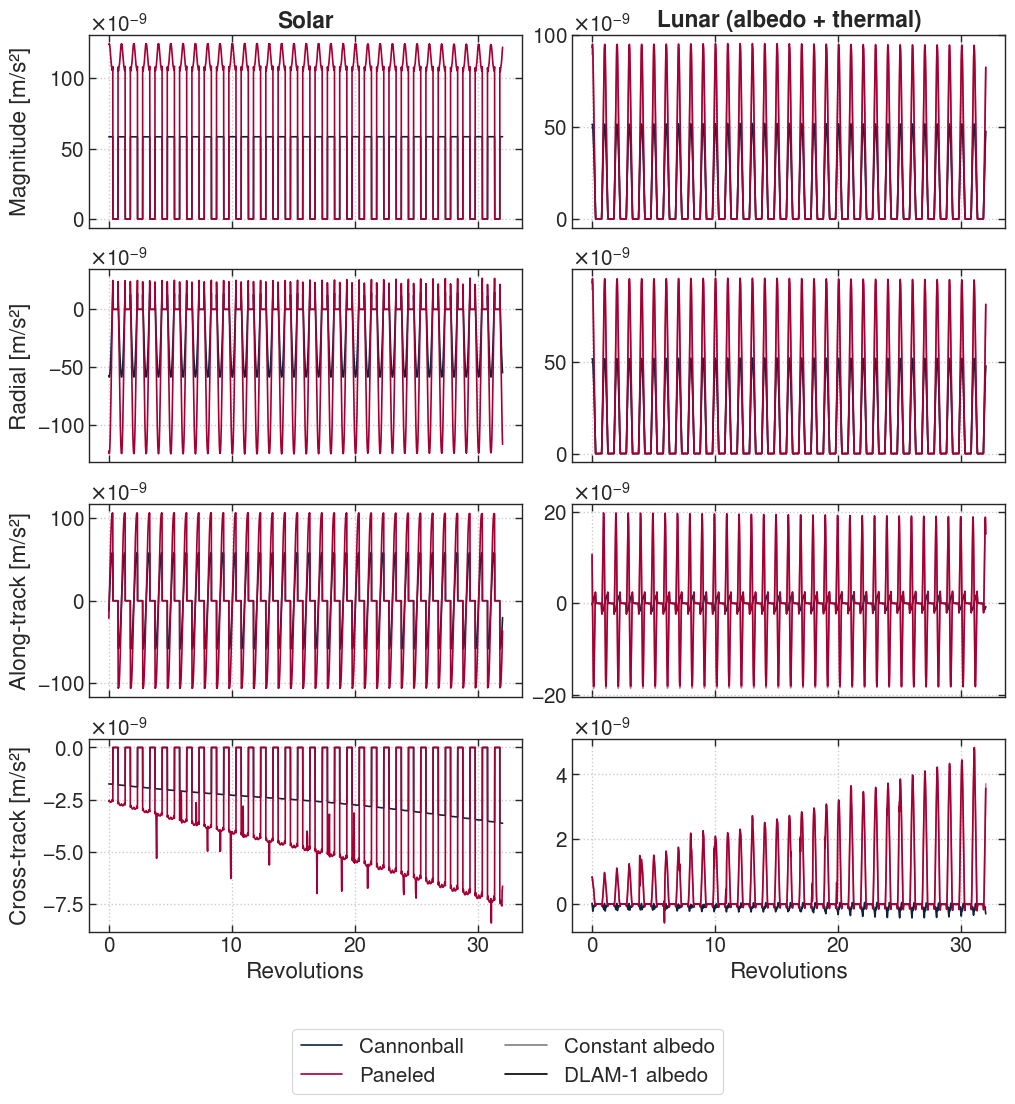

In [97]:
def plot_rp_accelerations(start_date):
    fig, axs = plt.subplots(4, 2, figsize=(10, 10), sharex="all")

    for i, (target_type, albedo_distribution_moon) in enumerate(itertools.product(["Cannonball", "Paneled"], ["constant", "DLAM-1"])):
        run = get_run(start_date, True, True, target_type, albedo_distribution_moon, "AngleBased")
        time = get_revolutions_index(run)

        color = f"C{int(target_type == 'Paneled')}"
        alpha = 0.5 if albedo_distribution_moon == "constant" else 1

        # run = run.rolling(orbit_steps).mean()

        if albedo_distribution_moon == "constant":
            ax_mag, ax_radial, ax_along, ax_cross = axs[:, 0]
            ax_mag.plot(time, run[f"acc_rp_sun"], color=color)
            ax_radial.plot(time, run[f"acc_rp_sun_radial"], color=color)
            ax_along.plot(time, run[f"acc_rp_sun_along"], color=color)
            ax_cross.plot(time, run[f"acc_rp_sun_cross"], color=color)

        ax_mag, ax_radial, ax_along, ax_cross = axs[:, 1]
        ax_mag.plot(time, run[f"acc_rp_moon"], alpha=alpha, color=color)
        ax_radial.plot(time, run[f"acc_rp_moon_radial"], alpha=alpha, color=color)
        ax_along.plot(time, run[f"acc_rp_moon_along"], alpha=alpha, color=color)
        ax_cross.plot(time, run[f"acc_rp_moon_cross"], alpha=alpha, color=color)
    
    fig.legend(
        [
            Line2D([0], [0], color="C0"),
            Line2D([0], [0], color="C1"),
            Line2D([0], [0], color="black", alpha=0.5),
            Line2D([0], [0], color="black", alpha=1),
        ],
        ["Cannonball", "Paneled", "Constant albedo", "DLAM-1 albedo"],
        bbox_to_anchor=(0.5, -0.12), loc="lower center", ncol=2)

    axs[0, 0].set_title("Solar")
    axs[0, 1].set_title("Lunar (albedo + thermal)")

    for ax in axs[-1, :].flat:
        # Last row
        # ax.set_xlim(17, 20)
        ax.set_xlabel("Revolutions")

    for ax, name in zip(axs[:, 0].flat, ["Magnitude", "Radial", "Along-track", "Cross-track"]):
        # First column
        ax.set_ylabel(name + r" [m/s²]")
    
    for ax in axs.flat:
        ax.ticklabel_format(axis="y", style="sci", scilimits=(-9, -9), useMathText=True)
        ax.set_ylim([min(0, ax.get_ylim()[0]), max(0, ax.get_ylim()[1])])
    
    format_plot(major_grid=True)

plot_rp_accelerations("2010 JUN 28")
plot_rp_accelerations("2011 SEP 26")

No interesting evolution, only changes are due to slight change in beta angle.

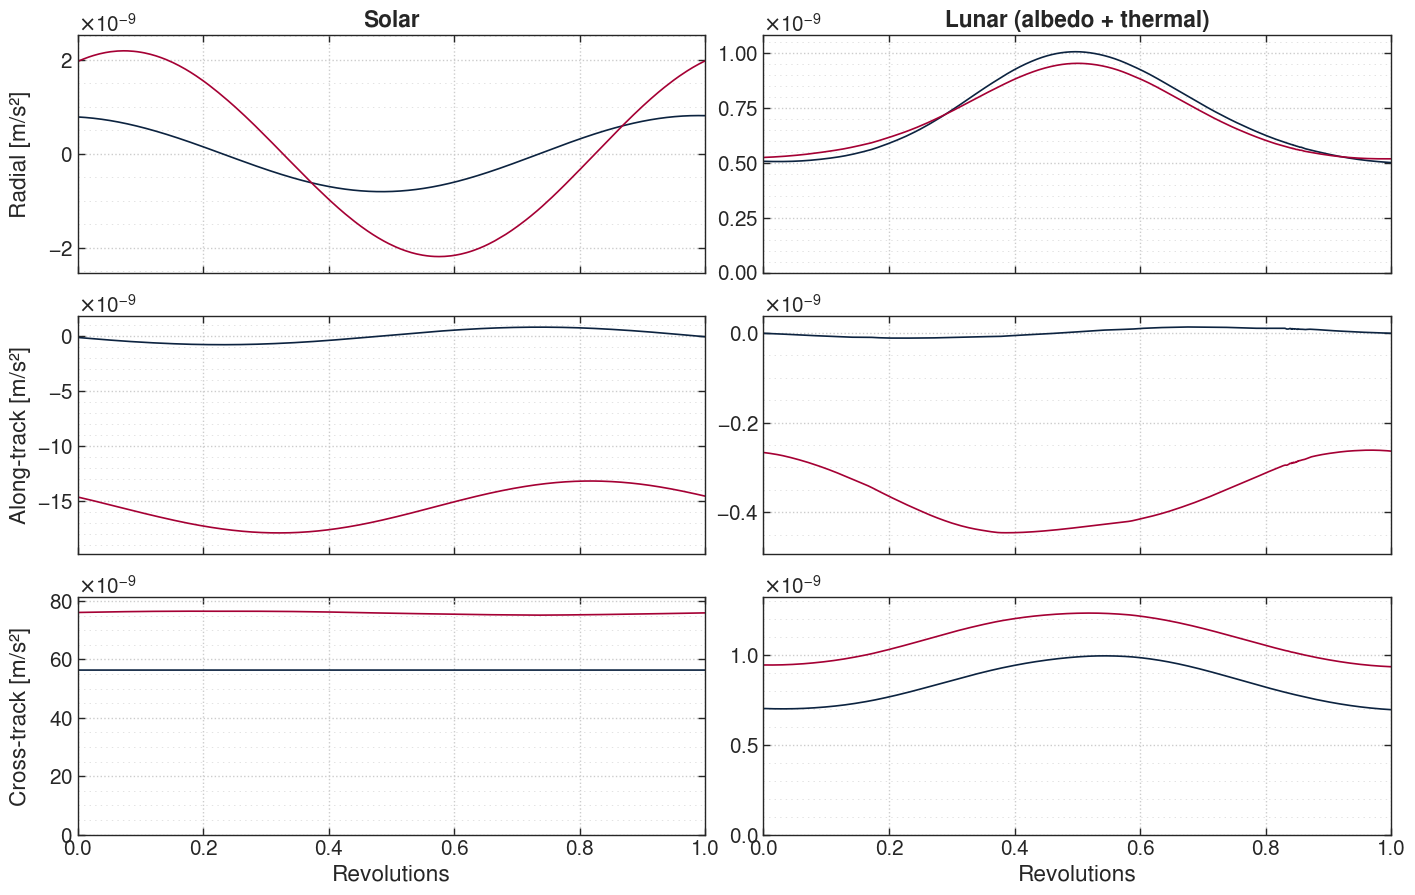

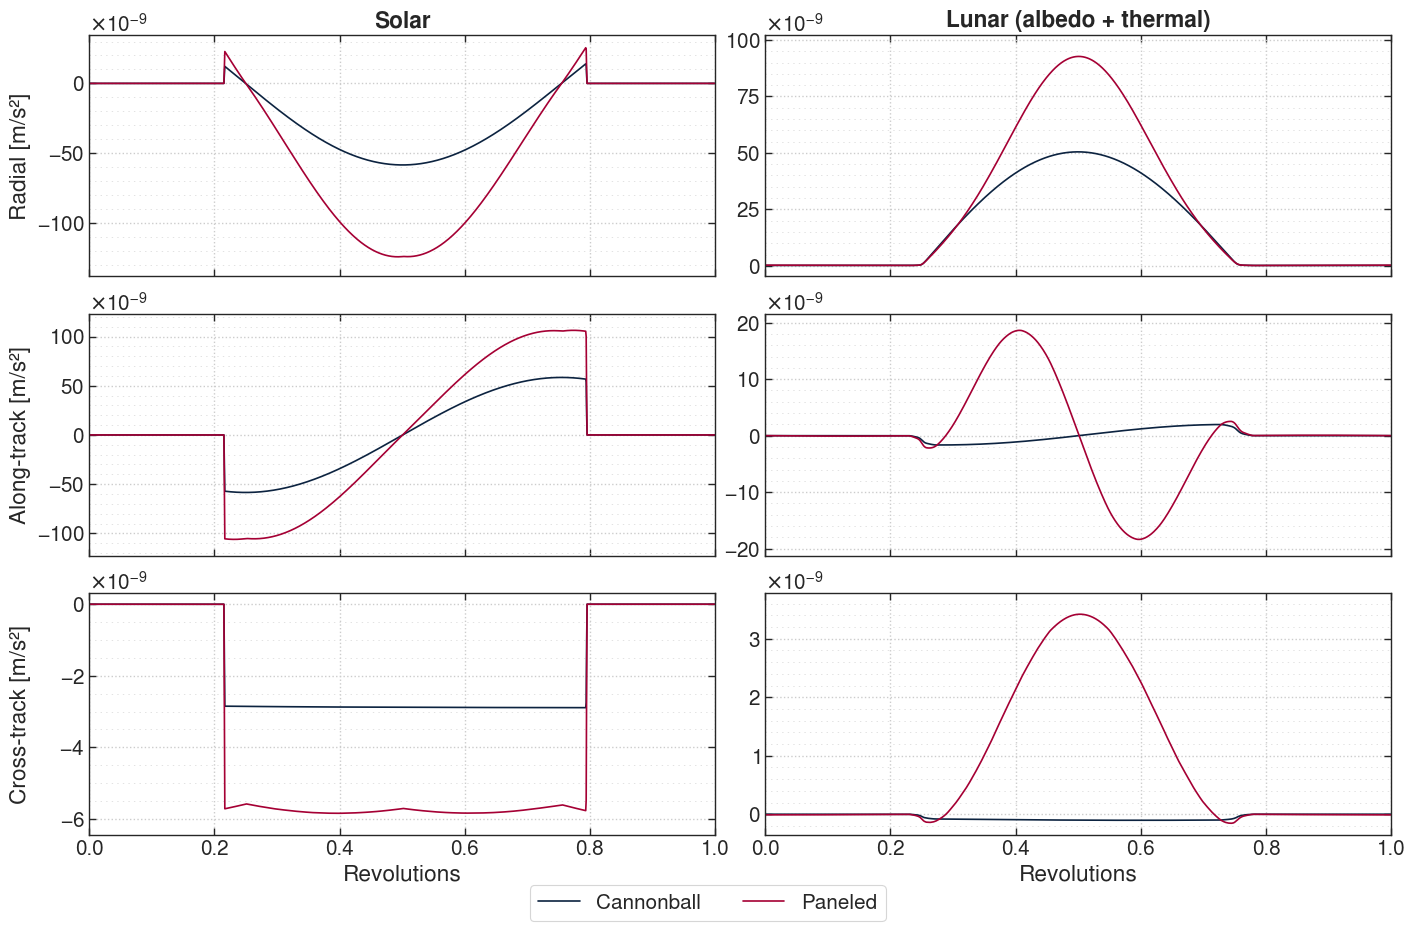

In [98]:
def plot_acc_solarvslunar_single_orbit(start_date, start_index, filename, legend=True):
    fig, axs = plt.subplots(3, 2, figsize=(14, 8.8), sharex="all")

    for i, target_type in enumerate(["Cannonball", "Paneled"]):
        run = get_run(start_date, True, True, target_type, "constant", "AngleBased")
        run = trim_df_revolutions(run, start_index)
        time = run.index

        color = f"C{int(target_type == 'Paneled')}"

        ax_radial, ax_along, ax_cross = axs[:, 0]
        ax_radial.plot(time, run[f"acc_rp_sun_radial"], color=color)
        ax_along.plot(time, run[f"acc_rp_sun_along"], color=color)
        ax_cross.plot(time, run[f"acc_rp_sun_cross"], color=color)

        ax_radial, ax_along, ax_cross = axs[:, 1]
        ax_radial.plot(time, run[f"acc_rp_moon_radial"], color=color)
        ax_along.plot(time, run[f"acc_rp_moon_along"], color=color)
        ax_cross.plot(time, run[f"acc_rp_moon_cross"], color=color)
    
    if legend:
        fig.legend(
            [
                Line2D([0], [0], color="C0"),
                Line2D([0], [0], color="C1"),
            ],
            ["Cannonball", "Paneled"],
            bbox_to_anchor=(0.5, -0.05), loc="lower center", ncols=2)

    axs[0, 0].set_title("Solar")
    axs[0, 1].set_title("Lunar (albedo + thermal)")

    for ax in axs[-1, :].flat:
        # Last row
        ax.set_xlim([0, 1])
        ax.set_xlabel("Revolutions")

    for ax, name in zip(axs[:, 0].flat, ["Radial", "Along-track", "Cross-track"]):
        # First column
        ax.set_ylabel(name + r" [m/s²]")
    
    for ax in axs.flat:
        ax.ticklabel_format(axis="y", style="sci", scilimits=(-9, -9), useMathText=True)
        ax.set_ylim([min(0, ax.get_ylim()[0] * 1.05), max(0, ax.get_ylim()[1] * 1.05)])
    
    format_plot(major_grid=True, minor_grid=True, x_minor_locator=NullLocator())
    save_plot(plots_folder, filename)

plot_acc_solarvslunar_single_orbit("2010 JUN 28", 21.92, "acc_solarvslunar_jun", legend=False)
plot_acc_solarvslunar_single_orbit("2011 SEP 26", 21.55, "acc_solarvslunar_sep")

2010 JUN 28 3.7504730494599325e-11 14.087058285342541 14.775341706042225 15.41486623875886 13.986460763317845
9.452320655773068e-10 23.9896059404406 39.4251770044374
2011 SEP 26 3.6615595587078753e-09 16.07376854192124 16.183399434838588 14.709583934495118 16.89429152967748
1.543980883111186e-10 5.83825508720221 1549.22113640754


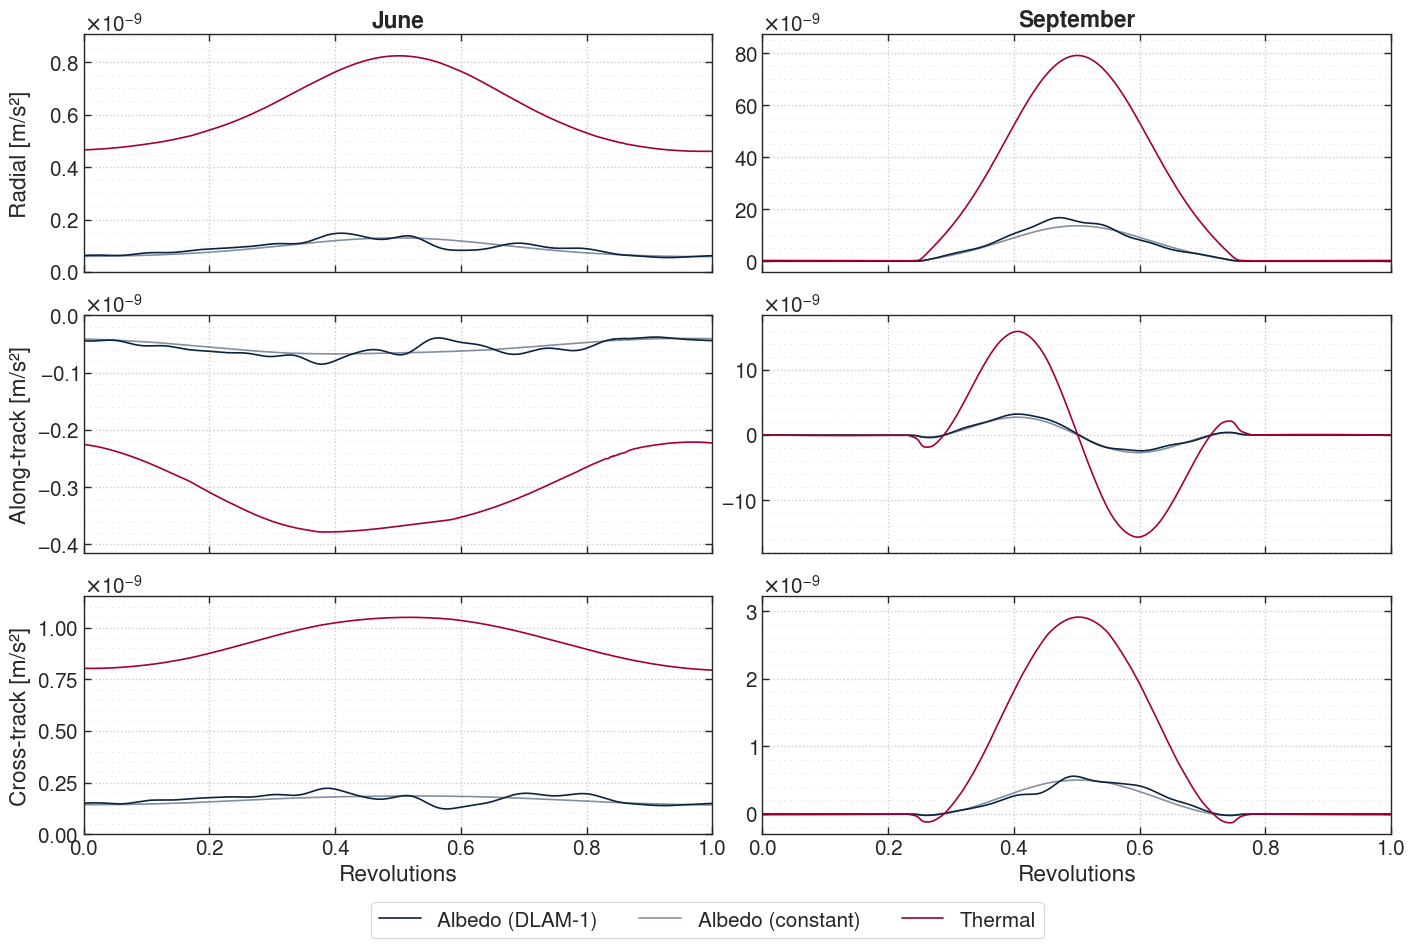

In [99]:
def plot_acc_albedovsthermal_single_orbit():
    fig, axs = plt.subplots(3, 2, figsize=(14, 8.8), sharex="all")

    albedo_color = "C0"
    thermal_color = "C1"

    for i, (start_date, start_index) in enumerate(zip(["2010 JUN 28", "2011 SEP 26"], [21.92, 21.55])):
        ax_radial, ax_along, ax_cross = axs[:, i]

        run_albedo_const = get_run(start_date, False, True, "Paneled", "constant", "NoThermal")
        run_albedo_const = trim_df_revolutions(run_albedo_const, start_index)

        run_albedo_dlam = get_run(start_date, False, True, "Paneled", "DLAM-1", "NoThermal")
        run_albedo_dlam = trim_df_revolutions(run_albedo_dlam, start_index)

        run_thermal = get_run(start_date, False, True, "Paneled", "NoAlbedo", "AngleBased")
        run_thermal = trim_df_revolutions(run_thermal, start_index)

        print(start_date,
            (run_albedo_dlam[f"acc_rp_moon_radial"]- run_albedo_const[f"acc_rp_moon_radial"]).abs().max(),
            rrmse(run_albedo_dlam[f"acc_rp_moon"], run_albedo_const[f"acc_rp_moon"], ignore_zeros=True)*100,
            rrmse(run_albedo_dlam[f"acc_rp_moon_radial"], run_albedo_const[f"acc_rp_moon_radial"], ignore_zeros=True)*100,
            rrmse(run_albedo_dlam[f"acc_rp_moon_along"], run_albedo_const[f"acc_rp_moon_along"], ignore_zeros=True)*100,
            rrmse(run_albedo_dlam[f"acc_rp_moon_cross"], run_albedo_const[f"acc_rp_moon_cross"], ignore_zeros=True)*100
        )
        print(run_thermal["acc_rp_moon"].min(), run_thermal["irr_moon"].min(), run_thermal["irr_moon"].max())

        ax_radial.plot(run_albedo_const.index, run_albedo_const[f"acc_rp_moon_radial"], alpha=0.5, color=albedo_color)
        ax_along.plot(run_albedo_const.index, run_albedo_const[f"acc_rp_moon_along"], alpha=0.5, color=albedo_color)
        ax_cross.plot(run_albedo_const.index, run_albedo_const[f"acc_rp_moon_cross"], alpha=0.5, color=albedo_color)

        ax_radial.plot(run_albedo_dlam.index, run_albedo_dlam[f"acc_rp_moon_radial"], alpha=1, color=albedo_color)
        ax_along.plot(run_albedo_dlam.index, run_albedo_dlam[f"acc_rp_moon_along"], alpha=1, color=albedo_color)
        ax_cross.plot(run_albedo_dlam.index, run_albedo_dlam[f"acc_rp_moon_cross"], alpha=1, color=albedo_color)

        ax_radial.plot(run_thermal.index, run_thermal[f"acc_rp_moon_radial"], color=thermal_color)
        ax_along.plot(run_thermal.index, run_thermal[f"acc_rp_moon_along"], color=thermal_color)
        ax_cross.plot(run_thermal.index, run_thermal[f"acc_rp_moon_cross"], color=thermal_color)
    
    fig.legend(
        [
            Line2D([0], [0], color=albedo_color),
            Line2D([0], [0], color=albedo_color, alpha=0.5),
            Line2D([0], [0], color=thermal_color),
        ],
        ["Albedo (DLAM-1)", "Albedo (constant)", "Thermal"],
        bbox_to_anchor=(0.5, -0.07), loc="lower center", ncol=3)

    axs[0, 0].set_title("June")
    axs[0, 1].set_title("September")

    for ax in axs[-1, :].flat:
        # Last row
        ax.set_xlim([0, 1])
        ax.set_xlabel("Revolutions")

    for ax, name in zip(axs[:, 0].flat, ["Radial", "Along-track", "Cross-track"]):
        # First column
        ax.set_ylabel(name + r" [m/s²]")
    
    for ax in axs.flat:
        ax.ticklabel_format(axis="y", style="sci", scilimits=(-9, -9), useMathText=True)
        ax.set_ylim([min(0, ax.get_ylim()[0] * 1.05), max(0, ax.get_ylim()[1] * 1.05)])
    
    format_plot(major_grid=True, minor_grid=True, x_minor_locator=NullLocator())
    save_plot(plots_folder, "acc_albedovsthermal")

plot_acc_albedovsthermal_single_orbit()

Albedo at max: 0.042963413356093355
Latitude difference to subsolar point: 12.371230881362646


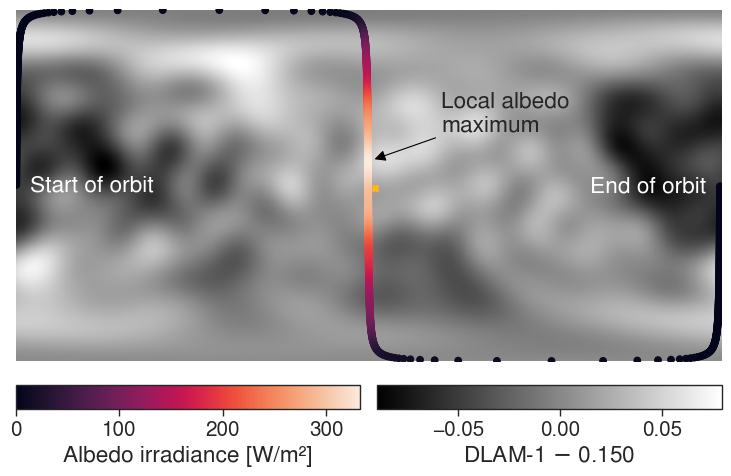

In [100]:
def plot_ground_track():
    # dist = tf_mosaic(imread("files/albedo.jpg")) - (0.19467246 / 1.3)
    dist = np.load("../private/dlam1.npy") - (0.19467246 / 1.3)

    run = get_run("2011 SEP 26", False, True, "Paneled", "DLAM-1", "NoThermal")
    run = trim_df_revolutions(run, 21.55)

    pos_sun = spice.spkpos("Sun", run.iloc[0]["t_et"], "MOON_ME", "NONE", "Moon")[0]
    _, polar_sun, azi_sun = cart2spher(*pos_sun)
    lat_sun = np.degrees(np.pi / 2 - polar_sun)
    lon_sun = np.degrees(azi_sun)

    # fig, ax = plt.subplots(
    #     figsize=(9, 4),
    #     constrained_layout=True,
    #     subplot_kw={"projection": ccrs.PlateCarree(164, globe=moon_globe)})
    # dist = np.load("../private/dlam1.npy")

    fig = plt.figure(figsize=(9*0.8, 6*0.8), constrained_layout=True)
    gs = matplotlib.gridspec.GridSpec(2, 2, figure=fig, height_ratios=[8, 0.5]) 
    ax = fig.add_subplot(gs[0, :], projection=ccrs.PlateCarree(164, globe=moon_globe))
    cax1 = fig.add_subplot(gs[1, 0])
    cax2 = fig.add_subplot(gs[1, 1])
    
    ax.imshow(dist, transform=ccrs.PlateCarree(globe=moon_globe), extent=(-180, 180, -90, 90), cmap="gray")
    ax.scatter(
        run["lon_moon"], run["lat_moon"],
        transform=ccrs.PlateCarree(globe=moon_globe),
        c=run["irr_moon"], cmap="rocket"
    )
    # ax.gridlines(draw_labels=["bottom", "left"], crs=ccrs.PlateCarree(globe=moon_globe))
    ax.set_axis_off()

    ax.scatter(lon_sun, lat_sun, marker="X", c="C4", transform=ccrs.PlateCarree(globe=moon_globe))

    # Find location of maximum difference (code a few cells below)
    lat_max = 10.936625
    lon_max = 163.634892
    # ax.scatter(lon_max, lat_max, marker="X", c="C4", transform=ccrs.PlateCarree(globe=moon_globe))
    print("Albedo at max:", dist[int((90 - lat_max)*2), int((180 + lon_max)*2)])
    print("Latitude difference to subsolar point:", lat_max - lat_sun)

    ax.annotate(
        "Start of orbit",
        run.iloc[0][["lon_moon", "lat_moon"]],
        xytext=(10, 0),
        va="center",
        ha="left",
        color="white",
        textcoords="offset points",
        transform=ccrs.PlateCarree(globe=moon_globe)
    )

    ax.annotate(
        "End of orbit",
        run.iloc[-1][["lon_moon", "lat_moon"]],
        xytext=(-10, 0),
        va="center",
        ha="right",
        color="white",
        textcoords="offset points",
        transform=ccrs.PlateCarree(globe=moon_globe)
    )

    ax.annotate(
        "Local albedo\nmaximum",
        (lon_max+2, lat_max+2),
        xytext=(50, 50),
        va="top",
        ha="left",
        textcoords="offset points",
        arrowprops=dict(arrowstyle="-|>", color="black"),
        transform=ccrs.PlateCarree(globe=moon_globe)
    )

    cb1 = fig.colorbar(
        matplotlib.cm.ScalarMappable(norm=matplotlib.colors.Normalize(
            vmin=run["irr_moon"].min(), vmax=run["irr_moon"].max()
            ), cmap="rocket"),
        cax=cax1, orientation='horizontal', label="Albedo irradiance [W/m²]")
    cb1.ax.tick_params(direction="out", which="both")


    cb2 = fig.colorbar(
        matplotlib.cm.ScalarMappable(norm=matplotlib.colors.Normalize(
            vmin=dist.min(), vmax=dist.max()
            ), cmap="gray"),
        cax=cax2, orientation='horizontal', label="DLAM-1 $-$ 0.150")
    cb2.ax.tick_params(direction="out", which="both")

    save_plot(plots_folder, "groundtrack")
    
plot_ground_track()

## Small-scale investigations

Paragraph about secular variations in sun RP for june arc due to eccentrity:

(0.0048965889258934, 0.0079950705798913)

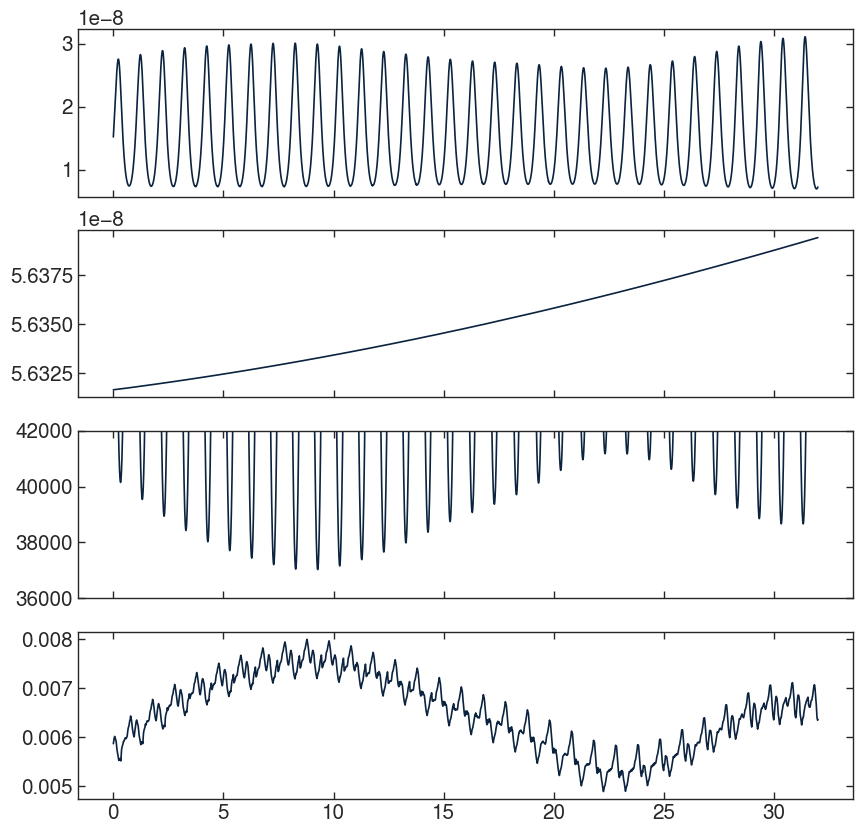

In [101]:
x = get_run("2010 JUN", True, True, "Cannonball", "constant", "AngleBased")
x.index = get_revolutions_index(x)
fig, axs = plt.subplots(4, 1, figsize=(10, 10), sharex=True)
axs[0].plot(x.index, x["irr_moon"] / (x["h"]**2))
axs[1].plot(x.index, x["acc_rp_sun"])
axs[2].plot(x.index, x["h"])
axs[2].set_ylim([36e3, 42e3])
# axs[3].plot(x.index, x["angle_subsolar"])
axs[3].plot(x.index, x["kepler_e"])
x["kepler_e"].min(), x["kepler_e"].max()
# axs[2].set_xlim([2, 4])

Total magnitudes for solar and lunar:

(1830.7333943267, 1361.87803110418)

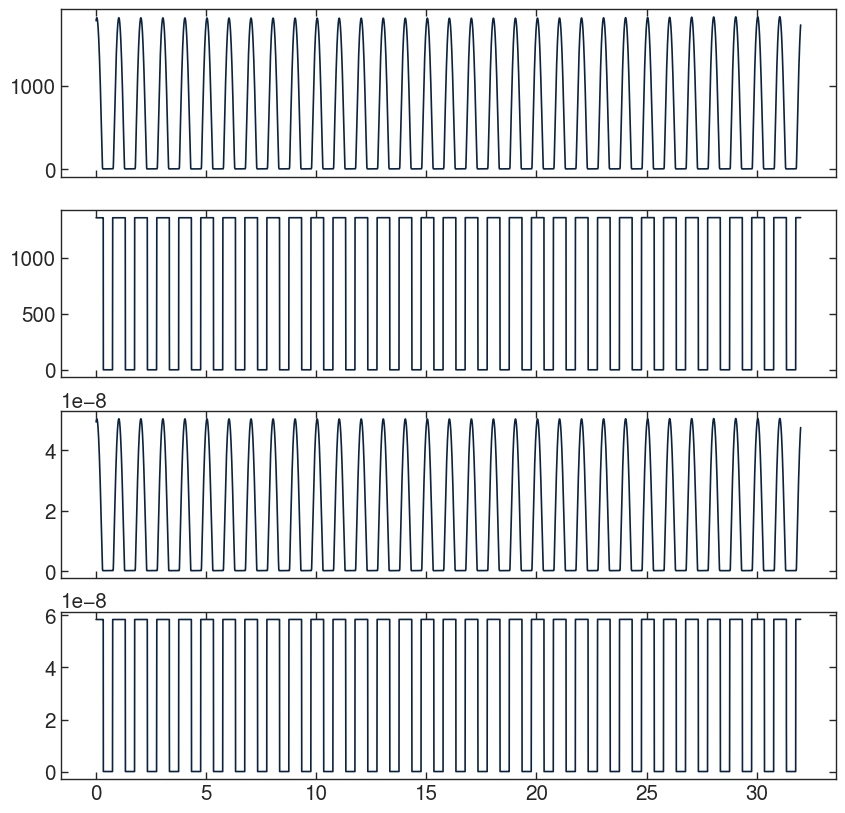

In [102]:
x = get_run("2011 SEP", True, True, "Cannonball", "constant", "AngleBased")
x.index = get_revolutions_index(x)
fig, axs = plt.subplots(4, 1, figsize=(10, 10), sharex=True)
axs[0].plot(x.index, x["irr_moon"])
axs[1].plot(x.index, x["irr_sun"])
axs[2].plot(x.index, x["acc_rp_moon"])
axs[3].plot(x.index, x["acc_rp_sun"])
x["irr_moon"].max(), x["irr_sun"].max()
# x["acc_rp_moon"].max(), x["acc_rp_sun"].max()

Subsolar angle of peak along-track lunar RP in september arc:

33.63648363789538

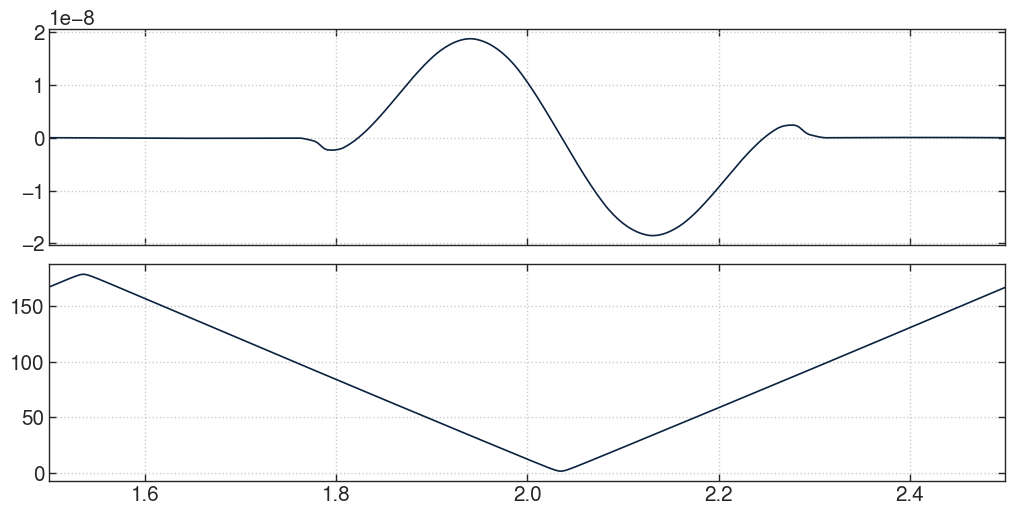

In [103]:
x = get_run("2011 SEP", True, True, "Paneled", "constant", "AngleBased")
x.index = get_revolutions_index(x)
fig, axs = plt.subplots(2, 1, figsize=(10, 5), sharex=True)
axs[0].plot(x.index, x["acc_rp_moon_along"])
axs[1].plot(x.index, x["angle_subsolar"])
axs[1].set_xlim([1.5, 2.5])
format_plot(major_grid=True)
x["angle_subsolar"].loc[x["acc_rp_moon_along"].loc[1.5:2.5].idxmax()]

Selenographic location of maximum difference between DLAM and constant (for ground track plot):

lat_moon     10.936625
lon_moon    163.634892
Name: 0.4659598625713315, dtype: float64

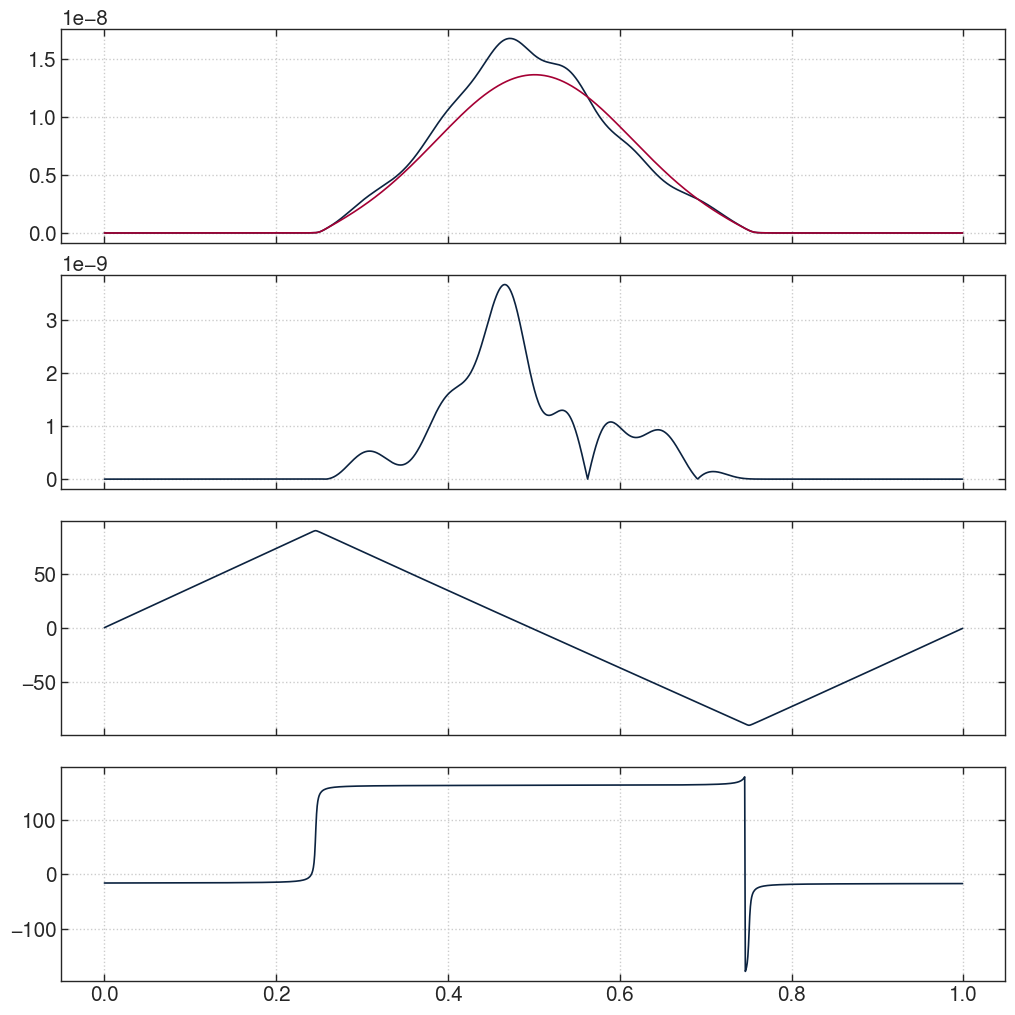

In [104]:
x = get_run("2011 SEP", True, True, "Paneled", "DLAM-1", "NoThermal")
x_const = get_run("2011 SEP", True, True, "Paneled", "constant", "NoThermal")
x = trim_df_revolutions(x, 21.55)
x_const = trim_df_revolutions(x_const, 21.55)
fig, axs = plt.subplots(4, 1, figsize=(10, 10), sharex=True)
axs[0].plot(x.index, x["acc_rp_moon_radial"])
axs[0].plot(x_const.index, x_const["acc_rp_moon_radial"])
axs[1].plot(x.index, (x["acc_rp_moon_radial"] - x_const["acc_rp_moon_radial"]).abs())
axs[2].plot(x.index, x["lat_moon"])
axs[3].plot(x.index, x["lon_moon"])
format_plot(major_grid=True)
idxmax = (x["acc_rp_moon_radial"] - x_const["acc_rp_moon_radial"]).abs().idxmax()
x.loc[idxmax][["lat_moon", "lon_moon"]]

# Change in final position

In [105]:
def get_position_error_df(start_date, target_type):
    df = []
    run_baseline = get_baseline(start_date).iloc[-2*orbit_steps:]
    runs = [
        get_run(start_date, True, False, target_type, "", ""),
        get_run(start_date, False, True, target_type, "constant", "AngleBased"),
        get_run(start_date, False, True, target_type, "DLAM-1", "AngleBased"),
        get_run(start_date, True, True, target_type, "DLAM-1", "AngleBased"),
    ]
    labels = [
        "solar",
        "lunar_const",
        "lunar_dlam",
        "solar_lunar"
    ]

    for label, run in zip(labels, runs):
        # Only use last 2 orbits since we are interested in the final error
        run = run.iloc[-2*orbit_steps:]

        error_names = [f"error_{name}" for name in pos_names]

        error = run[pos_names] - run_baseline[pos_names]
        error.columns = error_names
        error[pos_names] = run_baseline[pos_names]
        error[vel_names] = run_baseline[vel_names]

        def error_components(row):
            pos = row[pos_names].to_numpy()
            vel = row[vel_names].to_numpy()
            err = row[error_names].to_numpy()
            row["error_radial"], row["error_along"], row["error_cross"] = cart2track(err, vel, pos)
            return row

        error = error.apply(error_components, axis=1)
        error["error_total"] = np.linalg.norm(error[error_names], axis=1)
        error_mean = error.rolling(orbit_steps).mean()
        # De-trend error to find periodic variations
        variances = error.iloc[-orbit_steps:] - error_mean.iloc[-orbit_steps:]

        rms = np.sqrt(np.mean(
            np.linalg.norm(run[pos_names] - run_baseline[pos_names], axis=1)**2
            ))

        df.append({
            "label": label,
            "rms": rms,
            "e_total": error["error_total"].iloc[-1],
            "e_total_min": variances["error_total"].min(),
            "e_total_max": variances["error_total"].max(),
            "e_radial": error_mean["error_radial"].iloc[-1],
            "e_radial_min": variances["error_radial"].min(),
            "e_radial_max": variances["error_radial"].max(),
            "e_along": error_mean["error_along"].iloc[-1],
            "e_along_min": variances["error_along"].min(),
            "e_along_max": variances["error_along"].max(),
            "e_cross": error_mean["error_cross"].iloc[-1],
            "e_cross_min": variances["error_cross"].min(),
            "e_cross_max": variances["error_cross"].max(),
        })
    
    df = pd.DataFrame(df).reset_index(drop=True)

    return df

# get_position_error_df("2011 SEP 26", "Cannonball")

error_dfs = {}
for start_date, target_type in itertools.product(["2010 JUN 28", "2011 SEP 26"], ["Cannonball", "Paneled"]):
    error_dfs[(start_date, target_type)] = get_position_error_df(start_date, target_type)

with (results_folder / "position_errors.pkl").open("wb") as f:
    pickle.dump(error_dfs, f)

In [106]:
error_dfs = pd.read_pickle(results_folder / "position_errors.pkl")

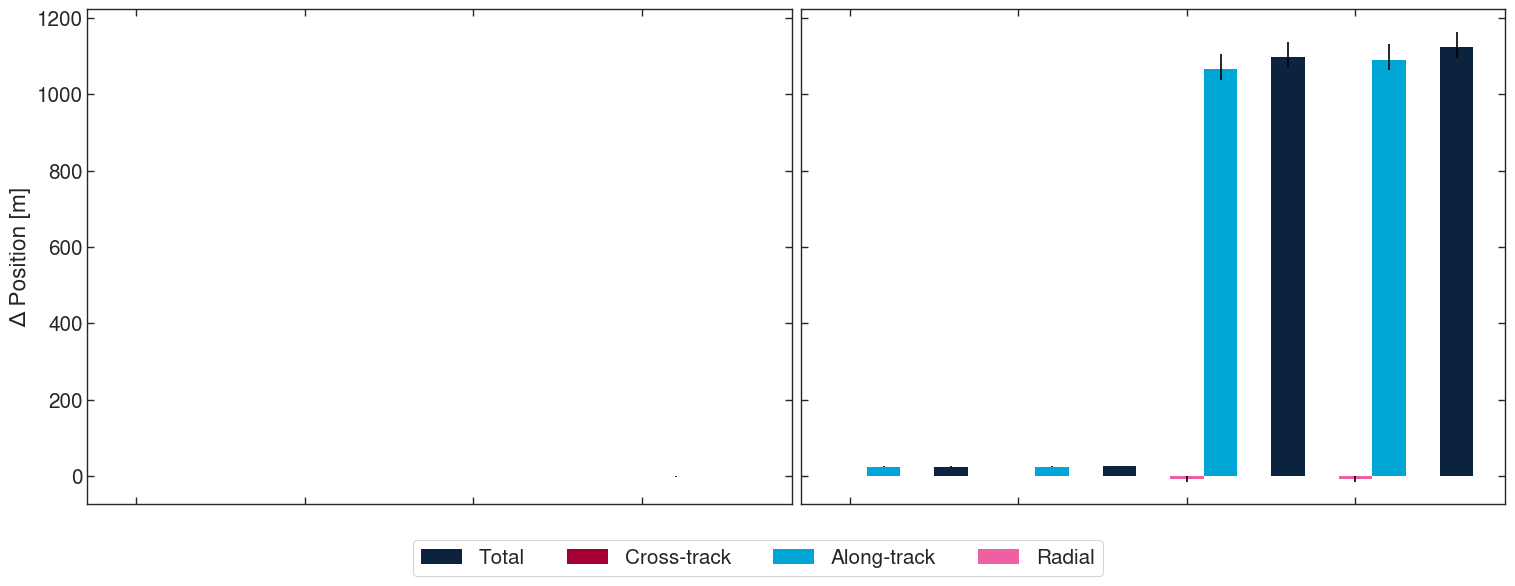

In [107]:
def plot_final_position_error(start_date):
    df_cannonball = error_dfs[(start_date, "Cannonball")]
    df_paneled = error_dfs[(start_date, "Paneled")]

    fig, (ax_cannonball, ax_paneled) = plt.subplots(1, 2, figsize=(15, 5), sharey="all")

    width = 1/5

    for j, (ax, df) in enumerate(zip([ax_cannonball, ax_paneled], [df_cannonball, df_paneled])):
       df = pd.DataFrame(df).sort_values("e_total").reset_index(drop=True)
       ax.bar(df.index + 3 * width, df["e_total"], width,
              yerr=df[["e_total_min", "e_total_max"]].abs().to_numpy().T, linewidth=0, label="Total" if j == 0 else None)
       ax.bar(df.index + 2 * width, df["e_cross"], width,
              yerr=df[["e_cross_min", "e_cross_max"]].abs().to_numpy().T, linewidth=0, label="Cross-track" if j == 0 else None)
       ax.bar(df.index + 1 * width, df["e_along"], width,
              yerr=df[["e_along_min", "e_along_max"]].abs().to_numpy().T, linewidth=0, label="Along-track" if j == 0 else None)
       ax.bar(df.index + 0 * width, df["e_radial"], width,
              yerr=df[["e_radial_min", "e_radial_max"]].abs().to_numpy().T, linewidth=0, label="Radial" if j == 0 else None)
       # print(df["e_radial"])
       # print(df["e_radial_min"])
       # print(df["e_radial_max"])
        
       ax.set_xticks(df.index + width, df["label"], rotation=15, ha="right")

    ax_cannonball.set_ylabel("Δ Position [m]")
    fig.legend(bbox_to_anchor=(0.5, -0.16), loc="lower center", ncol=4)
    
    format_plot(x_major_locator=FixedLocator(range(0, 4)))
    save_plot(plots_folder, "final_position_error")

plot_final_position_error("2010 JUN 28")
# plot_final_position_error("2011 SEP 26")

In [108]:
np.linalg.norm(get_baseline("2010 JUN 28")[vel_names], axis=1).mean()

1655.7196569120554

In [109]:
def generate_final_position_table(start_date, month):
    df_cannonball = error_dfs[(start_date, "Cannonball")]
    df_paneled = error_dfs[(start_date, "Paneled")]
    # print(df_cannonball)

    def format_uncertainty(row):
        row_fmt = {"label": row["label"]}
        for comp in ["radial", "along", "cross"]:
            label = {
                "total": "Total",
                "radial": "Radial",
                "along": "Along-track",
                "cross": "Cross-track",
            }
            mid = row['e_' + comp]
            mid = f"{mid:+.1f}"
            if mid == "-0.0":
                mid = "+0.0"

            upper = row['e_' + comp + '_max']
            assert upper >= 0
            # upper = f"+{upper:.1f}"

            lower = row['e_' + comp + '_min']
            # assert lower <= 0, lower
            # lower = f"{lower:+.1f}"
            amp = f"{max(abs(upper), abs(lower)):.1f}"

            # row_fmt[label[comp]] = "$" + mid + "_{" + lower + "}^{" + upper + "}$"
            row_fmt[label[comp]] = r"$\num{" + mid + " \pm " + amp + "}$"
        row_fmt["RMSE"] = r"$\num{" + f"{row['rms']:.1f}" + "}$"
        return pd.Series(row_fmt)

    df_cannonball = df_cannonball.apply(format_uncertainty, axis=1).set_index("label")
    df_paneled = df_paneled.apply(format_uncertainty, axis=1).set_index("label")

    df = pd.concat([df_cannonball, df_paneled], axis=1, keys=["Cannonball", "Paneled"])
    df.insert(4, "", "~")

    idx_names = {
        "solar": "A",
        "lunar_const": "B",
        "lunar_dlam": "C",
        "solar_lunar": "D",
    }
    # idx_names = {
    #     "solar": "Solar only",
    #     "lunar_const": "Lunar only (constant)",
    #     "lunar_dlam": "Lunar only (DLAM-1)",
    #     "solar_lunar": "Solar + lunar (DLAM-1)",
    # }
    df.index = df.index.map(idx_names)
    df = df.loc[idx_names.values()].rename_axis(index=None)

    table = (
        df.style
        .applymap_index(lambda v: "font-weight: bold;", axis="rows")
        .applymap_index(lambda v: "font-weight: bold;", axis="columns", level=0)
        .to_latex(convert_css=True, hrules=True, multicol_align="c")
    )

    table = table.replace("\midrule", "\cmidrule{2-5}\cmidrule{7-10}")

    print(table)
    with open(tables_folder + f"/final_position_{month}.tex", "w") as f:
        f.write(table)

generate_final_position_table("2010 JUN 28", "jun")
generate_final_position_table("2011 SEP 26", "sep")

\begin{tabular}{llllllllll}
\toprule
 & \multicolumn{4}{c}{\bfseries Cannonball} & \bfseries  & \multicolumn{4}{c}{\bfseries Paneled} \\
 & Radial & Along-track & Cross-track & RMSE &  & Radial & Along-track & Cross-track & RMSE \\
\cmidrule{2-5}\cmidrule{7-10}
\bfseries A & $\num{+0.0 \pm 0.2}$ & $\num{-0.5 \pm 0.5}$ & $\num{+0.1 \pm 0.1}$ & $\num{0.6}$ & ~ & $\num{-7.5 \pm 6.7}$ & $\num{+1066.1 \pm 39.3}$ & $\num{+0.1 \pm 0.2}$ & $\num{1033.5}$ \\
\bfseries B & $\num{+0.0 \pm 0.0}$ & $\num{-0.3 \pm 0.0}$ & $\num{+0.0 \pm 0.0}$ & $\num{0.3}$ & ~ & $\num{-0.2 \pm 0.2}$ & $\num{+24.4 \pm 0.9}$ & $\num{+0.0 \pm 0.0}$ & $\num{23.6}$ \\
\bfseries C & $\num{+0.0 \pm 0.0}$ & $\num{-0.3 \pm 0.0}$ & $\num{+0.0 \pm 0.0}$ & $\num{0.3}$ & ~ & $\num{-0.2 \pm 0.2}$ & $\num{+24.6 \pm 0.9}$ & $\num{+0.0 \pm 0.0}$ & $\num{23.9}$ \\
\bfseries D & $\num{+0.0 \pm 0.2}$ & $\num{-0.8 \pm 0.4}$ & $\num{+0.1 \pm 0.1}$ & $\num{0.8}$ & ~ & $\num{-7.7 \pm 6.9}$ & $\num{+1090.7 \pm 40.2}$ & $\num{+0.1 \pm 0.2}$ 

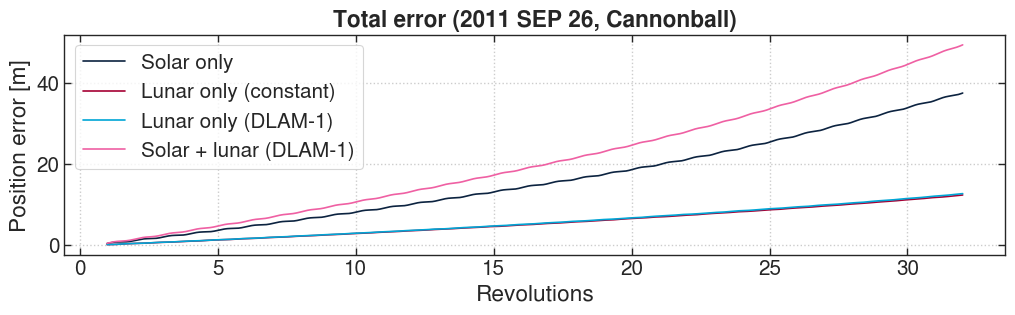

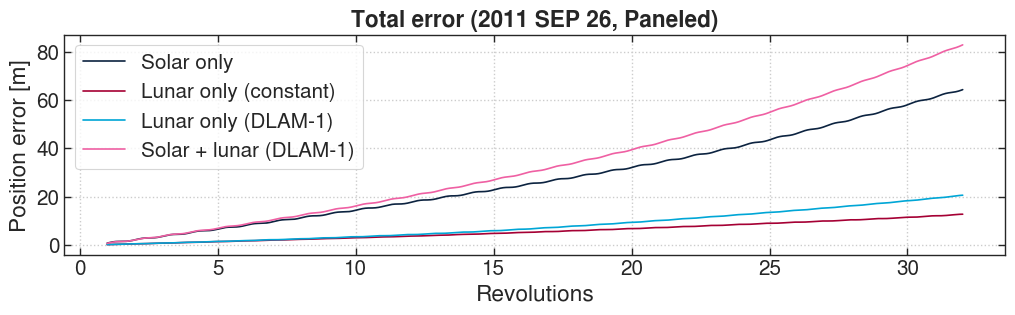

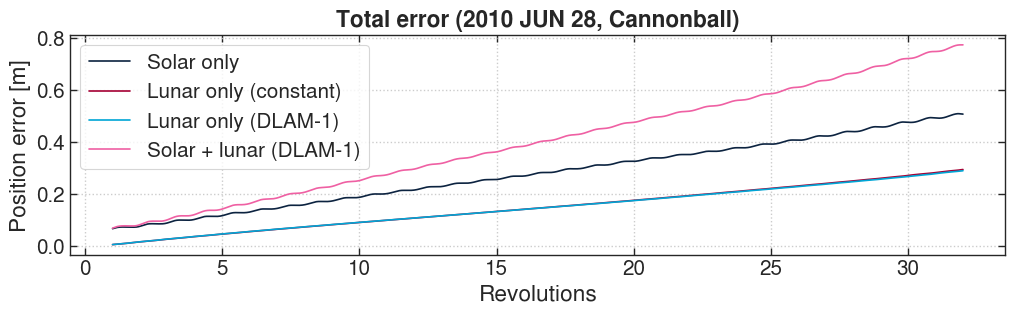

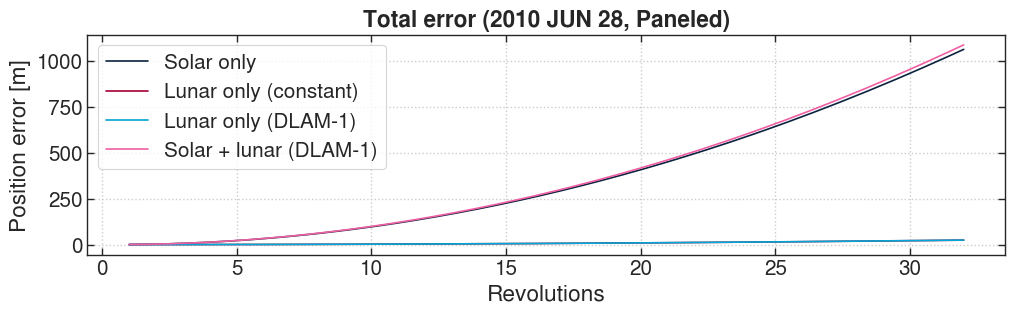

In [110]:
def plot_position_evolution(start_date, target_type):
    df_baseline = get_baseline(start_date)

    dfs = [
        get_run(start_date, True, False, target_type, "", ""),
        get_run(start_date, False, True, target_type, "constant", "AngleBased"),
        get_run(start_date, False, True, target_type, "DLAM-1", "AngleBased"),
        get_run(start_date, True, True, target_type, "DLAM-1", "AngleBased"),
    ]
    labels = [
        "Solar only",
        "Lunar only (constant)",
        "Lunar only (DLAM-1)",
        "Solar + lunar (DLAM-1)",
    ]

    fig, ax = plt.subplots(figsize=(10, 3), sharex=True, sharey=True)

    for df, label in zip(dfs, labels):
        ax.plot(get_revolutions_index(df_baseline),
            # df_baseline["angle_subsolar"] - df["angle_subsolar"],
            pd.Series(np.linalg.norm(df_baseline[pos_names] - df[pos_names], axis=1)).rolling(orbit_steps).mean(),
        label=label)
    
    ax.legend()
    ax.set_xlabel("Revolutions")
    ax.set_ylabel("Position error [m]")
    ax.set_title(f"Total error ({start_date}, {target_type})")
    # ax.set_xlim([30, 32])
    # ax.set_ylim([1000, 1100])

    format_plot(major_grid=True)


plot_position_evolution("2011 SEP 26", "Cannonball")
plot_position_evolution("2011 SEP 26", "Paneled")
plot_position_evolution("2010 JUN 28", "Cannonball")
plot_position_evolution("2010 JUN 28", "Paneled")

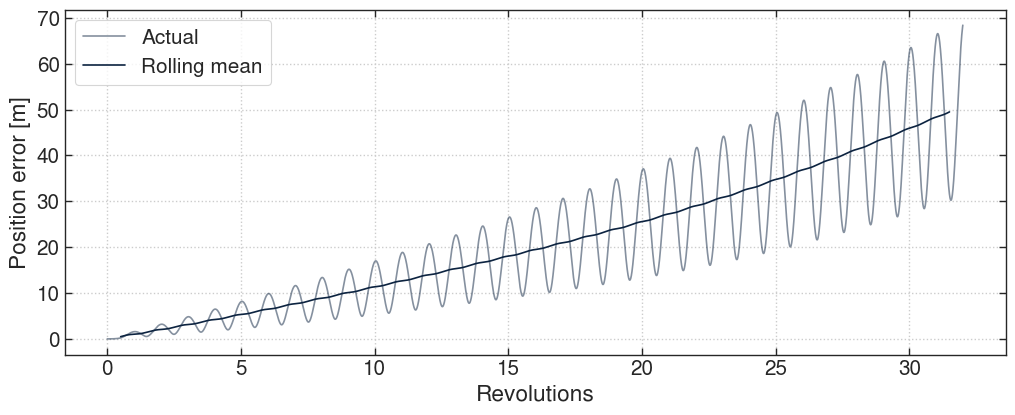

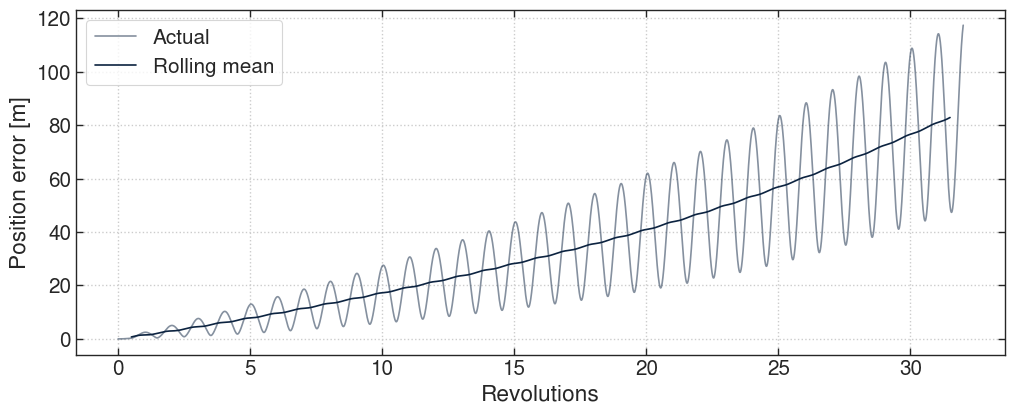

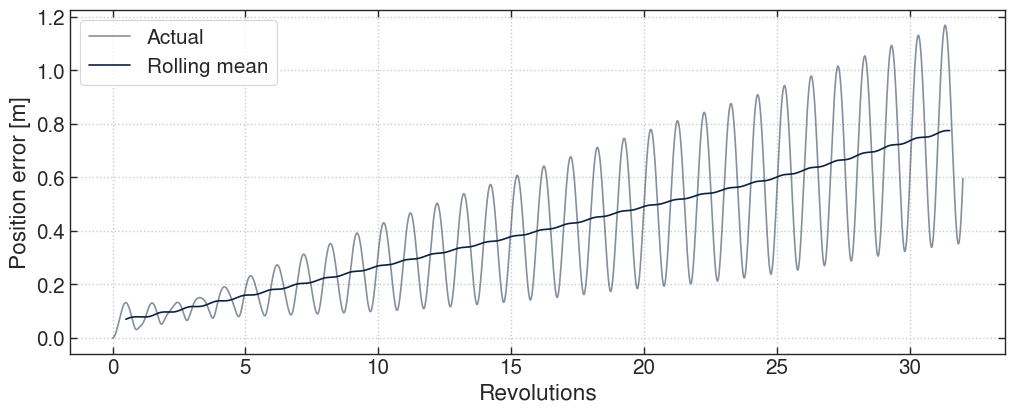

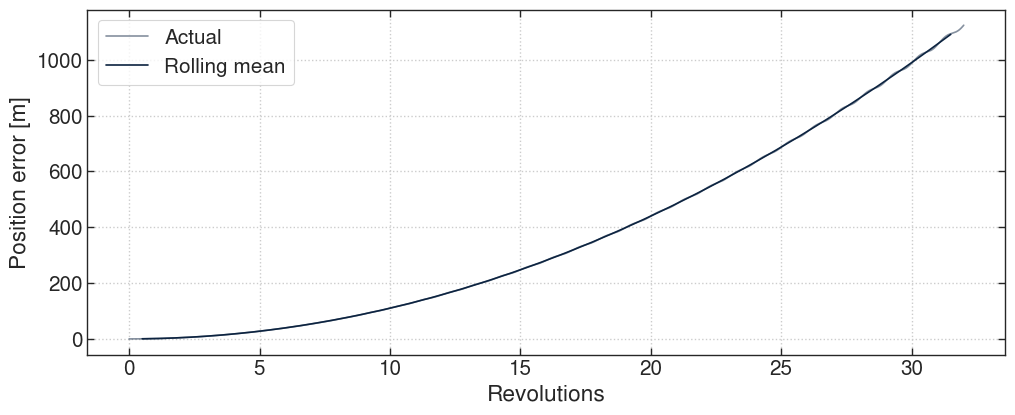

In [111]:
def plot_position_evolution_simple(start_date, target_type):
    df_baseline = get_baseline(start_date)

    df = get_run(start_date, True, True, target_type, "DLAM-1", "AngleBased")

    fig, ax = plt.subplots(figsize=(10, 4), sharex=True, sharey=True)

    x = pd.Series(np.linalg.norm(df_baseline[pos_names] - df[pos_names], axis=1))
    ax.plot(get_revolutions_index(df_baseline),
        x,
    label="Actual", c="C0", alpha=0.5)
    ax.plot(get_revolutions_index(df_baseline), x.rolling(orbit_steps, center=True).mean(),
    label="Rolling mean", c="C0", alpha=1)
    
    ax.legend()
    ax.set_xlabel("Revolutions")
    ax.set_ylabel("Position error [m]")
    # ax.set_title(f"Total error ({start_date}, {target_type})")
    # ax.set_xlim([30, 32])
    # ax.set_ylim([1000, 1100])

    format_plot(major_grid=True)
    # save_plot(plots_folder, f"position_evolution_{start_date}_{target_type}", type="png")


plot_position_evolution_simple("2011 SEP 26", "Cannonball")
plot_position_evolution_simple("2011 SEP 26", "Paneled")
plot_position_evolution_simple("2010 JUN 28", "Cannonball")
plot_position_evolution_simple("2010 JUN 28", "Paneled")

# Orbital elements

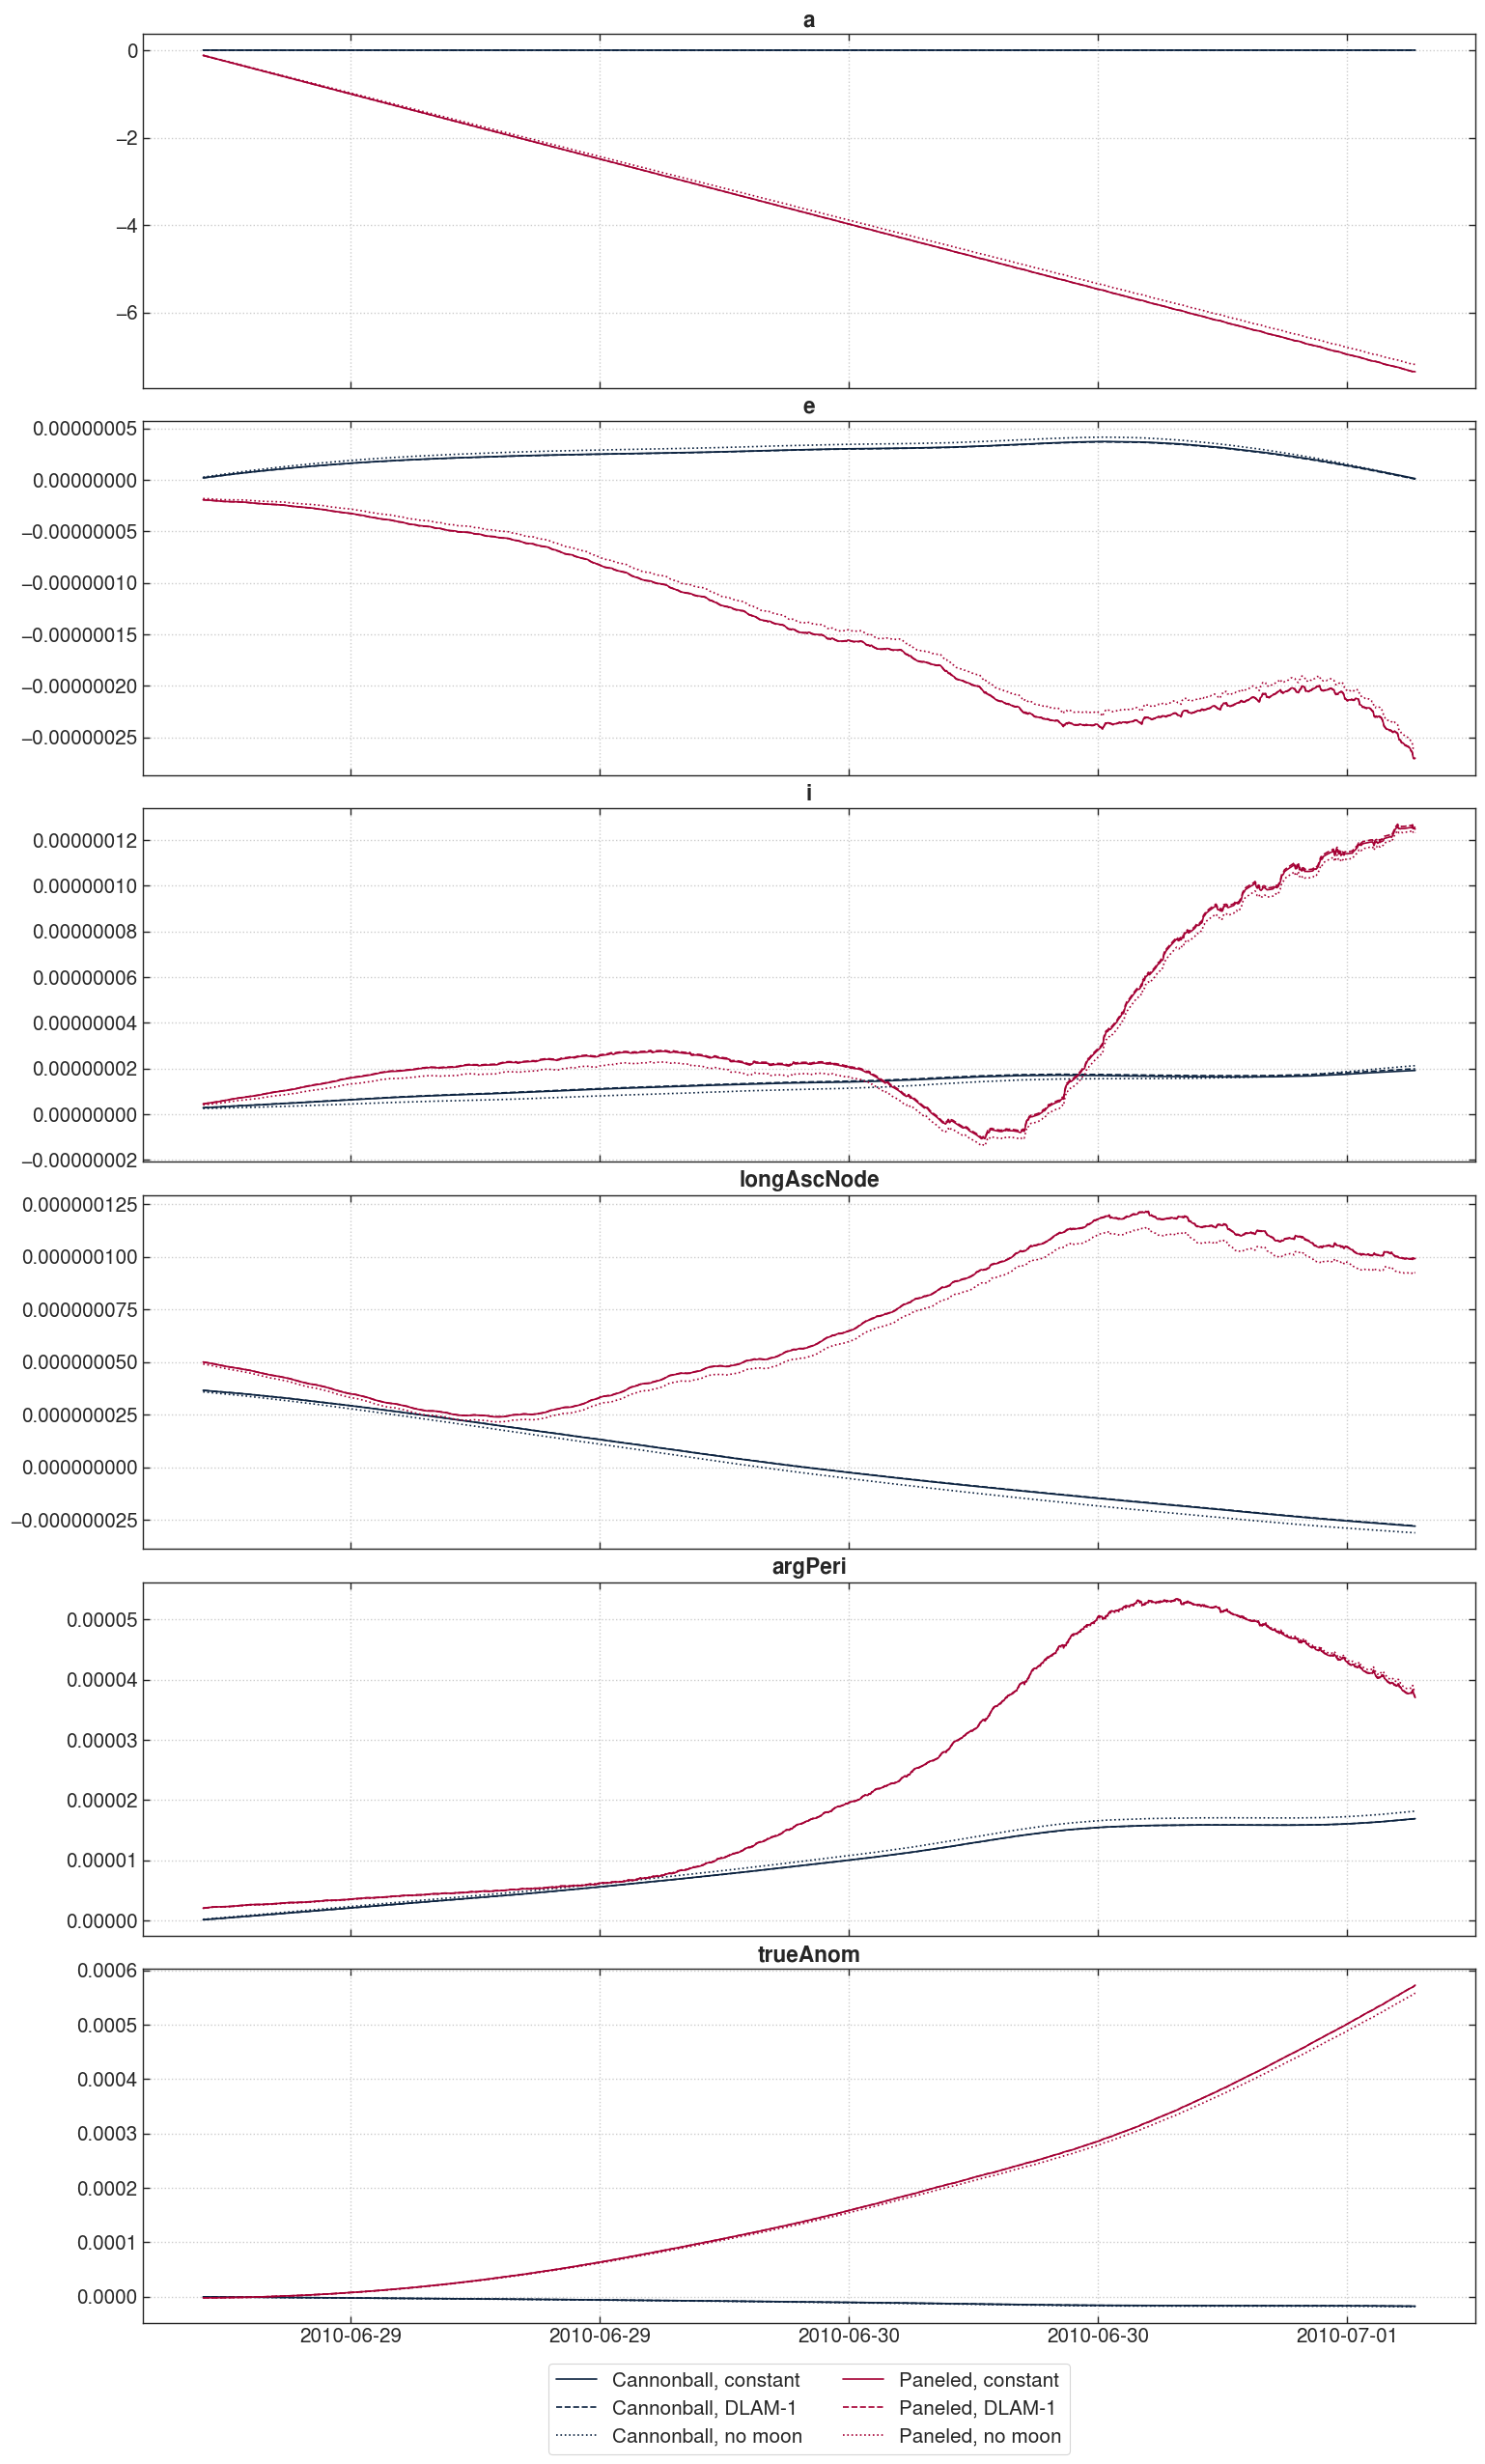

In [112]:
def plot_kepler_elements(start_date, mean=False, percent=False):
    fig, axs = plt.subplots(6, figsize=(15, 5*5), sharex="all")

    names = ["a", "e", "i", "longAscNode", "argPeri", "trueAnom"]

    df_baseline = get_baseline(start_date)

    for i, (target_type, albedo_distribution_moon) in enumerate(itertools.product(["Cannonball", "Paneled"], ["constant", "DLAM-1", None])):
        if albedo_distribution_moon is None:
            run = get_run(start_date, True, False, target_type, "", "")
        else:
            run = get_run(start_date, True, True, target_type, albedo_distribution_moon, "AngleBased")

        color = f"C{int(target_type == 'Paneled')}"
        ls = {
            "constant": "-",
            "DLAM-1": "--",
            None: ":"
        }[albedo_distribution_moon]

        for ax, name in zip(axs, names):
            y = run[f"kepler_{name}"] - df_baseline[f"kepler_{name}"]
            if percent:
                y *= 100 / df_baseline[f"kepler_{name}"]
                y = y[y < 100]
            else:
                y = y[y / df_baseline[f"kepler_{name}"] < 1]
            if mean:
                y = y.rolling(orbit_steps).mean()
            ax.plot(y.index, y, label=f"{target_type}, {albedo_distribution_moon or 'no moon'}", color=color, ls=ls)
    
    axs[-1].legend(bbox_to_anchor =(0.5,-0.4), loc="lower center", ncol=2)
    for ax, name in zip(axs, names):
        ax.set_title(name)
        ax.ticklabel_format(axis="y", style="plain")

    # axs[-1].set_xlim([dt(2010, 9, 27, 6), dt(2010, 9, 27, 6) + timedelta(minutes=3*113)])
    
    format_plot(major_grid=True)

# plot_kepler_elements("2010 JUN 28", mean=False, percent=False)
plot_kepler_elements("2010 JUN 28", mean=True, percent=False)
# plot_kepler_elements("2011 SEP 26", mean=True, percent=False)

In [113]:
def generate_elements_error_df(start_date, target_type):
    def true_to_mean_anom(row):
        f = row.kepler_trueAnom
        e = row.kepler_e
        x = np.sqrt(1-e**2)
        return np.arctan2(-x*np.sin(f), -e-np.cos(f)) + np.pi - e * x * np.sin(f) / (1 + e*np.cos(f))

    df = []
    run_baseline = get_baseline(start_date).iloc[-2*orbit_steps:].copy()
    run_baseline["kepler_meanAnom"] = run_baseline.apply(true_to_mean_anom, axis=1)
    runs = [
        get_run(start_date, True, False, target_type, "", ""),
        get_run(start_date, False, True, target_type, "constant", "AngleBased"),
        get_run(start_date, False, True, target_type, "DLAM-1", "AngleBased"),
        get_run(start_date, True, True, target_type, "DLAM-1", "AngleBased"),
    ]
    labels = [
        "solar",
        "lunar_const",
        "lunar_dlam",
        "solar_lunar"
    ]

    kepler_names = [f"kepler_{name}" for name in ["a", "e", "i", "argPeri", "longAscNode", "meanAnom"]]

    for label, run in zip(labels, runs):
        # Only use last 2 orbits since we are interested in the final error
        run = run.iloc[-2*orbit_steps:].copy()

        run["kepler_meanAnom"] = run.apply(true_to_mean_anom, axis=1)

        error = run[kepler_names] - run_baseline[kepler_names]
        error_mean = error.rolling(orbit_steps).mean()

        error_mean["kepler_i"] = np.degrees(error_mean["kepler_i"])
        error_mean["kepler_argPeri"] = np.degrees(error_mean["kepler_argPeri"])
        error_mean["kepler_longAscNode"] = np.degrees(error_mean["kepler_longAscNode"])
        error_mean["kepler_meanAnom"] = np.degrees(error_mean["kepler_meanAnom"])

        df.append({
            "label": label,
        } | {name: error_mean.iloc[-1][name] for name in kepler_names})
    
    df = pd.DataFrame(df)

    return df

# generate_elements_error_df("2010 JUN 28", "Paneled")

elements_error_dfs = {}
for start_date, target_type in itertools.product(["2010 JUN 28", "2011 SEP 26"], ["Cannonball", "Paneled"]):
    elements_error_dfs[(start_date, target_type)] = generate_elements_error_df(start_date, target_type)

In [114]:
def generate_elements_table(start_date, month):
    df_cannonball = elements_error_dfs[(start_date, "Cannonball")]
    df_paneled = elements_error_dfs[(start_date, "Paneled")]
    # print(df_cannonball)

    def format_uncertainty(row):
        row_fmt = {"label": row["label"]}
        for comp in [f"kepler_{name}" for name in ["a", "e", "i", "longAscNode", "argPeri"]]:
            row_fmt[comp] = r"\num{" + f"{row[comp]:+.2g}" "}"
        return pd.Series(row_fmt)

    df_cannonball = df_cannonball.apply(format_uncertainty, axis=1).set_index("label")
    df_paneled = df_paneled.apply(format_uncertainty, axis=1).set_index("label")

    df = pd.concat([df_cannonball, df_paneled], axis=1, keys=["Cannonball", "Paneled"])
    df.insert(5, "", "~")

    idx_names = {
        "solar": "Solar only",
        "lunar_const": "Lunar only (constant)",
        "lunar_dlam": "Lunar only (DLAM-1)",
        "solar_lunar": "Solar + lunar (DLAM-1)",
    }
    col_names = {
        "kepler_a": "$a$",
        "kepler_e": "$e$",
        "kepler_i": "$i$",
        "kepler_longAscNode": "$\Omega$",
        "kepler_argPeri": "$\omega$",
        "kepler_meanAnom": "$M$",
    }

    # Reorder
    df.index = df.index.map(idx_names)

    # Rename
    df = df.loc[idx_names.values()].rename_axis(index=None)
    df = df.rename(columns=col_names)

    table = (
        df.style
        .applymap_index(lambda v: "font-weight: bold;", axis="rows")
        .applymap_index(lambda v: "font-weight: bold;", axis="columns", level=0)
        .to_latex(convert_css=True, hrules=True, multicol_align="c")
    )

    table = table.replace("\midrule", "\cmidrule{2-6}\cmidrule{8-12}")

    print(table)
    with open(tables_folder + f"/final_elements_{month}.tex", "w") as f:
        f.write(table)

generate_elements_table("2010 JUN 28", "jun")
generate_elements_table("2011 SEP 26", "sep")

\begin{tabular}{llllllllllll}
\toprule
 & \multicolumn{5}{c}{\bfseries Cannonball} & \bfseries  & \multicolumn{5}{c}{\bfseries Paneled} \\
 & $a$ & $e$ & $i$ & $\Omega$ & $\omega$ &  & $a$ & $e$ & $i$ & $\Omega$ & $\omega$ \\
\cmidrule{2-6}\cmidrule{8-12}
\bfseries Solar only & \num{+0.0015} & \num{+8.3e-10} & \num{+1.2e-06} & \num{-1.8e-06} & \num{+0.001} & ~ & \num{-7.2} & \num{-2.6e-07} & \num{+7.1e-06} & \num{+5.3e-06} & \num{+0.0022} \\
\bfseries Lunar only (constant) & \num{+7.4e-05} & \num{+5.7e-10} & \num{-1.2e-07} & \num{+1.8e-07} & \num{-7.2e-05} & ~ & \num{-0.17} & \num{-8.6e-09} & \num{+8.8e-08} & \num{+3.9e-07} & \num{-4.8e-05} \\
\bfseries Lunar only (DLAM-1) & \num{+2.8e-05} & \num{+7e-11} & \num{-8e-08} & \num{+1.9e-07} & \num{-7.2e-05} & ~ & \num{-0.17} & \num{-9e-09} & \num{+1.4e-07} & \num{+4e-07} & \num{-4.3e-05} \\
\bfseries Solar + lunar (DLAM-1) & \num{+0.0015} & \num{+9e-10} & \num{+1.1e-06} & \num{-1.6e-06} & \num{+0.00097} & ~ & \num{-7.4} & \num{-2.7e-07} & \

In [115]:
from astropy import units as u
from poliastro.bodies import Moon
from poliastro.twobody import Orbit

r = [-6045, -3490, 2500] * u.km
v = [-3.457, 6.618, 2.533] * u.km / u.s

ss = Orbit.from_vectors(Earth, r, v)

ModuleNotFoundError: No module named 'poliastro'

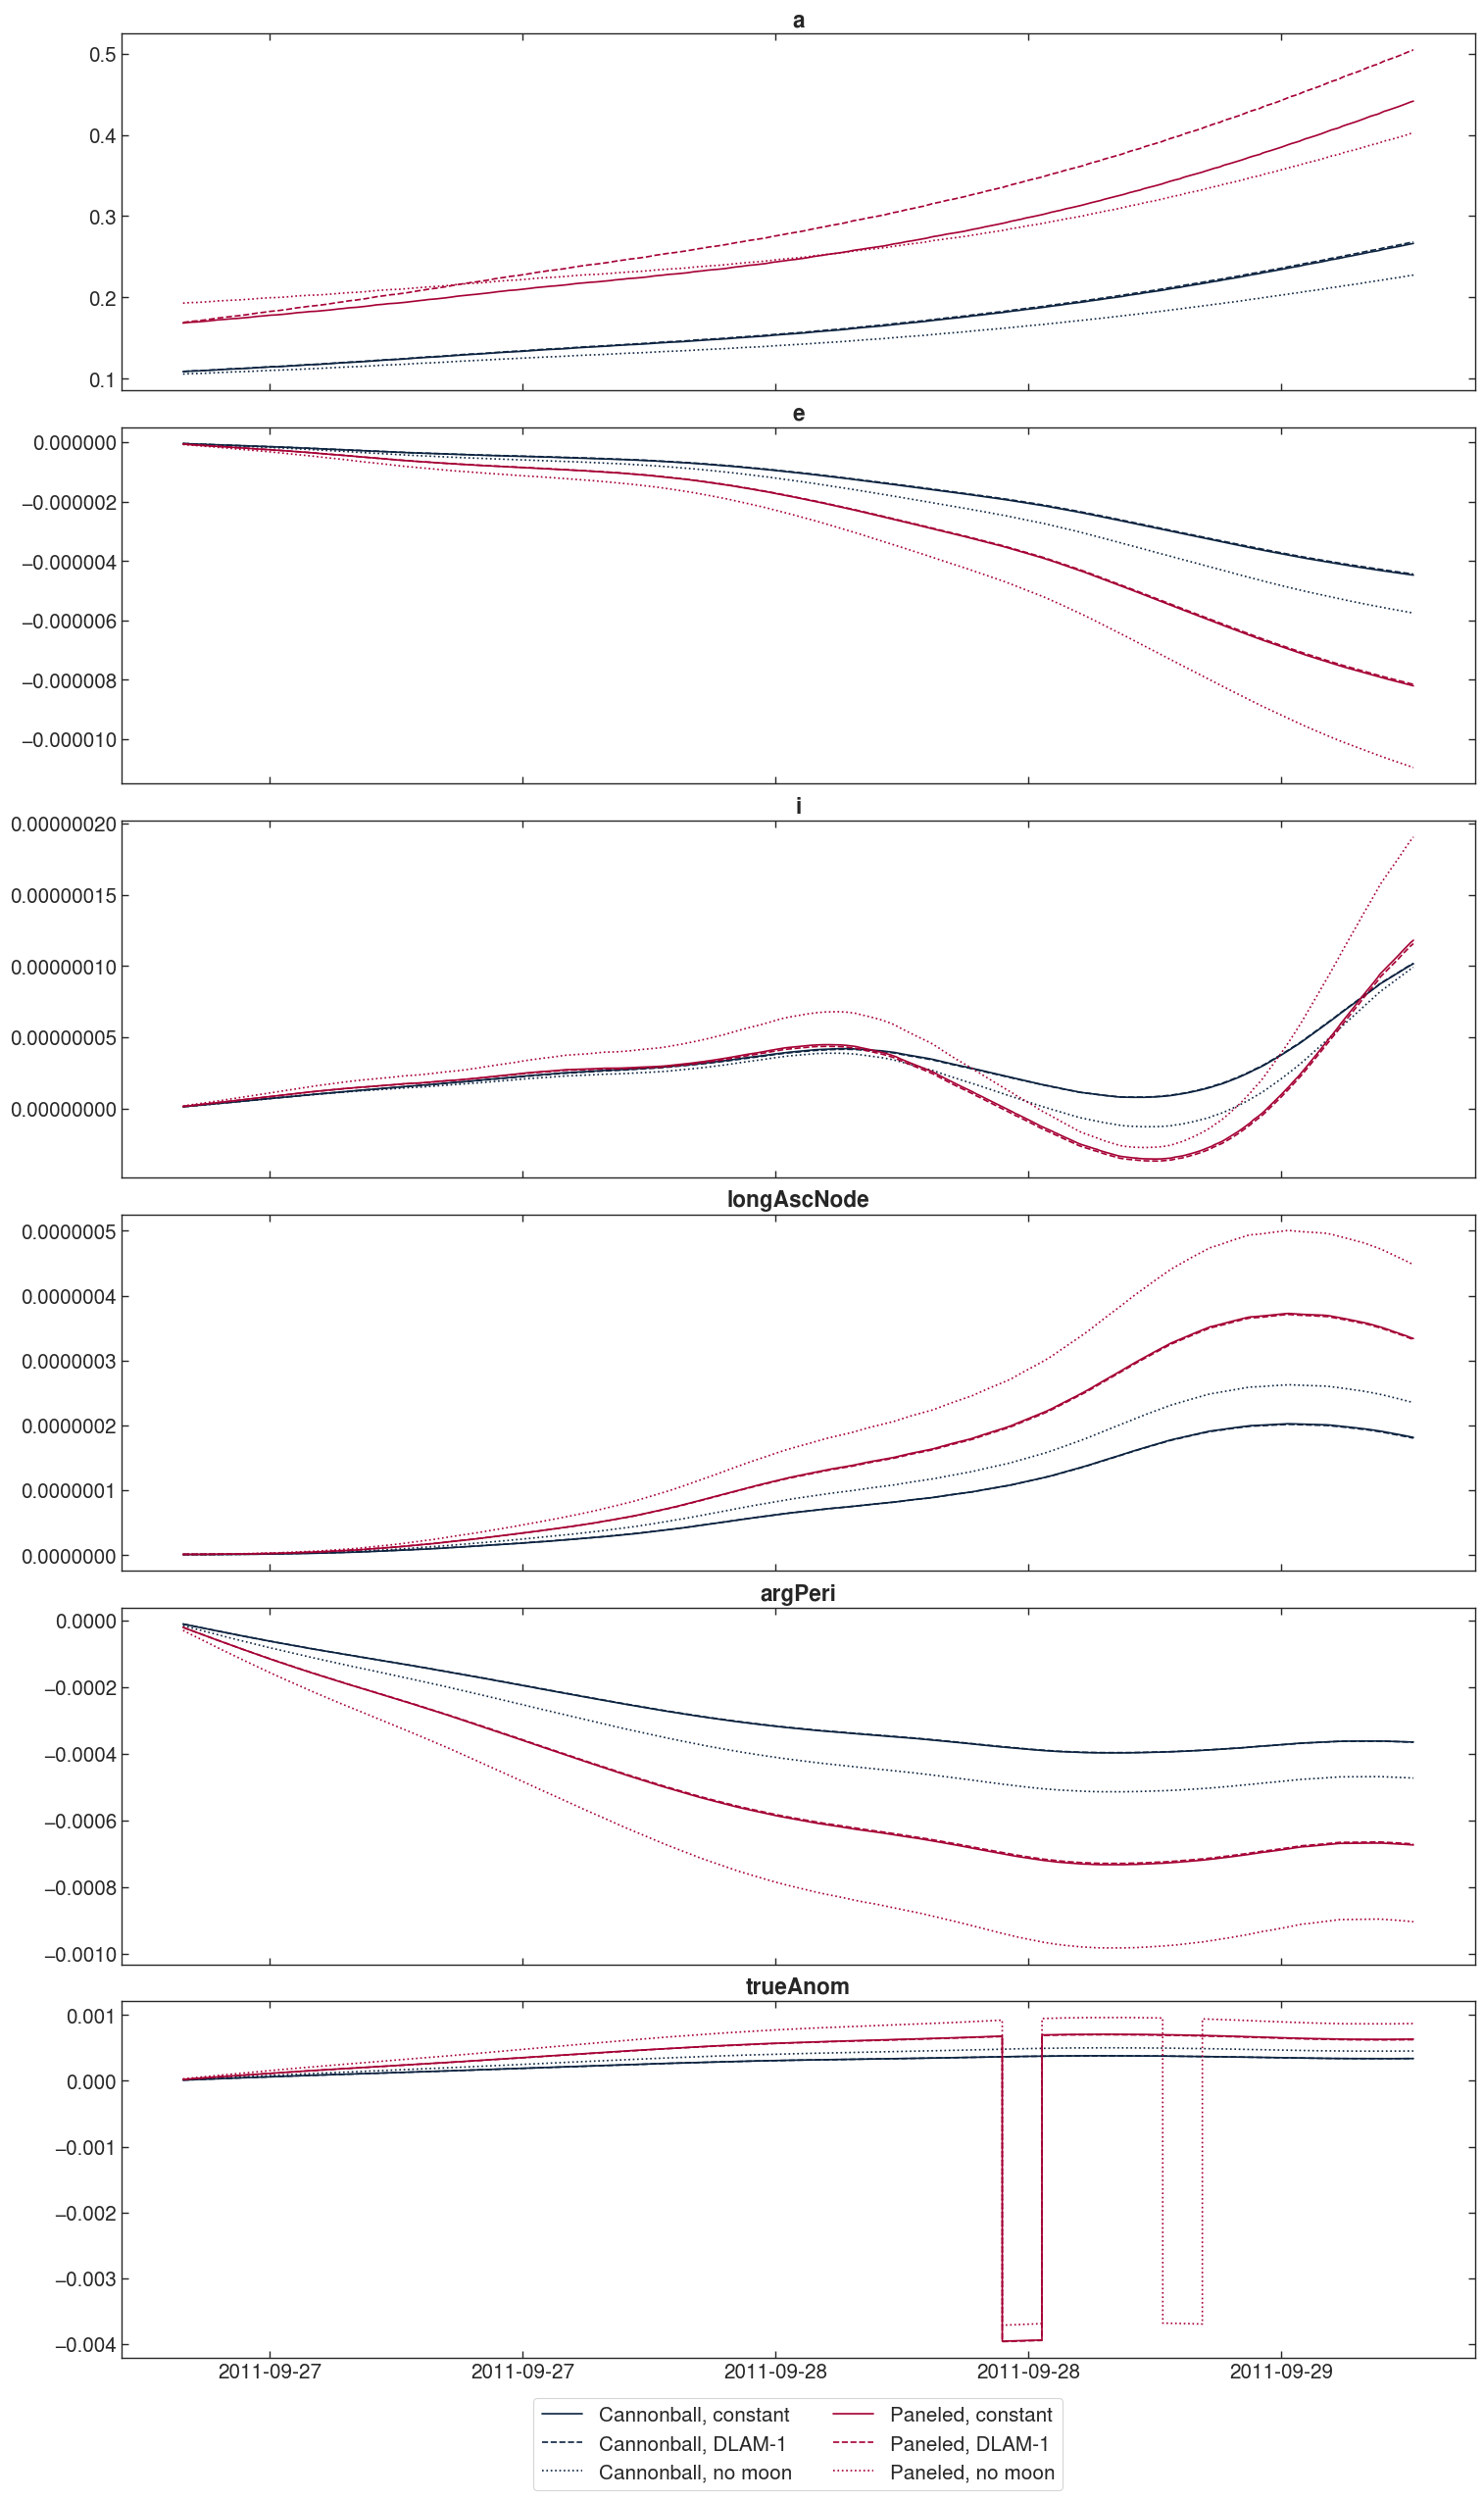

In [ ]:
plot_kepler_elements("2011 SEP 26", mean=True, percent=False)

June (beta = 90):
* Largest change in inclination

September (beta = 0):
* Largest changes in eccentricity and semi major axis